# Anticipez les besoins en consommation de bâtiments - *Notebook prediction SiteEnergyUseWN(kBtu)*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :


1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

In [4]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables catégorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, make_scorer, r2_score, mean_absolute_error

from sklearn import dummy
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.svm import SVR

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

import shap

shap.initjs()

import timeit
import warnings
from packaging.version import parse as parse_version

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)
print("shap version", shap.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0
shap version 0.46.0


## 1 - Création des fonctions et paramètres pour automatisation

### 1.1 - Fonction des modèles sans validation croisée

**Baseline avec DummyRegressor**

On va utiliser la stratégie de la moyenne : prédit la moyenne des valeurs cibles d'entraînement. Créons la fonction qui prend les jeux d'entraînement et de tests et en entrée, et retourne les scores MSE, RMSE, R2, MAE:

In [8]:
def fit_dummyRegressor(X_train, y_train, X_test, y_test):

    start_time = timeit.default_timer()
    
    # Initialisation du DummyRegressor avec la stratégie 'mean'
    dummy_regressor = DummyRegressor(strategy='mean')
    
    # Entraînement du modèle
    dummy_regressor.fit(X_train, y_train)
    
    # Prédiction sur les données de test
    y_pred = dummy_regressor.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Modèle de régression Ridge**

La régression ridge nous permet de réduire l'amplitude des coefficients d'une régression linéaire et d'éviter le sur-apprentissage. On optimisera l'hyperparamètre alpha lors de la validation croisée avec GridSearchCV. Pour rappel, dans le cadre de la régression Ridge, l'hyperparamètre alpha contrôle le degré de régularisation L2 appliqué au modèle. Il agit comme un paramètre de pénalisation pour limiter la taille des coefficients du modèle afin de réduire le sur-ajustement.

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [10]:
def fit_ridge(X_train, y_train, X_test, y_test):

    start_time = timeit.default_timer()
    
    # Initialisation du modèle Ridge avec un paramètre alpha
    ridge_regressor = Ridge(alpha=1)  # alpha contrôle la régularisation ; plus grand, plus de régularisation ( 1 = valeur par défaut)
    
    # Entraînement du modèle
    ridge_regressor.fit(X_train, y_train)
    
    # Prédiction sur les données de test
    y_pred = ridge_regressor.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Modèle de régression Lasso**

Le Lasso est une méthode de sélection de variables et de réduction de dimension supervisée : les variables qui ne sont pas nécessaires à la prédiction de l'étiquette sont éliminées. l'hyperparamètre alpha contrôle l'intensité de la pénalisation L1 appliquée au modèle. Il prendre la valeur par défaut 1 ici.

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [12]:
def fit_lasso(X_train, y_train, X_test, y_test):

    start_time = timeit.default_timer()
    
    # Initialisation du modèle Lasso avec un paramètre alpha
    lasso_regressor = Lasso(alpha=1)  # alpha contrôle la régularisation ; plus grand, plus de régularisation
    
    # Entraînement du modèle
    lasso_regressor.fit(X_train, y_train)
    
    # Prédiction sur les données de test
    y_pred = lasso_regressor.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Modèle ElasticNet**

La méthode elastic net qui combine les deux termes de régularisation en un (Ridge L2 et Lasso L1). Deux hyperparamètres principaux sont à ajuster :
- alpha : contrôle la force globale de la régularisation (combine L1 et L2). (Par défaut = 1)
- l1_ratio : détermine la pondération entre la pénalisation L1 (type LASSO) et L2 (type Ridge). (Par défaut = 0.5)

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [14]:
def fit_elasticNet(X_train, y_train, X_test, y_test):

    start_time = timeit.default_timer()

    # Initialisation du modèle ElasticNet
    elastic_net = ElasticNet(
        alpha=1, 
        l1_ratio=0.5, # Mélange égal entre ridge et lasso
        max_iter=1000, random_state=42
    )

    # Entraînement du modèle
    elastic_net.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = elastic_net.predict(X_test)
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Bagging - Modèle RamdonForestRegressor**

Appelé aussi le bagging qui, appliqué aux arbres de décision, donne naissance au modèle de forêt aléatoire. 

Une forêt aléatoire est un ensemble de nombreux arbres de décision qui sont combinés pour produire une prédiction plus précise et plus robuste. Chaque arbre de décision est construit à partir d'un échantillon aléatoire des données et les résultats sont moyennés pour obtenir la prédiction finale. 

Le modèle de forêt aléatoire est intrinsèquement parallèle. Les arbres sont entraînés en même temps sur des parties du dataset.

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [16]:
def fit_ramdomForestRegressor(X_train, y_train, X_test, y_test, data_columns):

    start_time = timeit.default_timer()
    
    # Création du modèle
    # n_estimators : Nombre d'arbres dans la forêt. Valeur par défaut = 100. Une valeur plus élevée peut améliorer la précision mais augmente le temps de calcul.
    model = RandomForestRegressor(n_estimators=100, random_state=42) 
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    # Afficher l'importance des features
    print("Importance des features dans le RandomForestRegressor :")
    importances = model.feature_importances_
    # Création d'un DataFrame pour afficher l'importance des features
    feature_importance = pd.DataFrame({'Feature': data_columns, 'Importance': importances})
    # Tri par ordre d'importance décroissante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Afficher les résultats
    print(feature_importance)

    return mse, rmse, r2, mae, elapsed

**Boosting - Modèle GradientBoostingRegressor**

Le boosting enchaîne l'entraînement des prédicteurs faibles de façon séquentielle, en se concentrant à chaque itération sur les échantillons qui ont généré le plus d'erreurs.

Il s'agit d'une méthode d'ensemble qui construit un modèle prédictif puissant en combinant plusieurs modèles faibles (typiquement des arbres de décision) de manière séquentielle

Le modèle de forêt aléatoire est intrinsèquement parallèle. Les arbres sont entraînés en même temps sur des parties du dataset.

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [18]:
def fit_gradientBoostingRegressor(X_train, y_train, X_test, y_test):

    start_time = timeit.default_timer()

    # Création du modèle de régression Gradient Boosting
    gb_regressor = GradientBoostingRegressor(
        n_estimators=100,  # Nombre d'arbres
        learning_rate=0.1,  # Taux d'apprentissage (ici valeur par défaut)
        max_depth=3,  # Profondeur maximale des arbres (ici valeur par défaut)
        random_state=42  # Pour la reproductibilité
    )

    # Entraînement du modèle
    gb_regressor.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = gb_regressor.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Modèle SVR**

Pour effectuer une régression avec un SVM (Support Vector Machine), on utilise le modèle appelé Support Vector Regression (SVR), qui fait partie des algorithmes de régression basés sur les SVM.

Le SVR cherche à trouver une fonction qui ne s'écarte pas trop des valeurs cibles, avec un contrôle sur la marge d'erreur autorisée.

Créons une fonction qui permet d'instancier le modèle, l'entraîner, et calculer les scores:

In [20]:
def fit_SVR(X_train, y_train, X_test, y_test):
    
    start_time = timeit.default_timer()
    
    # Initialisation du modèle SVR
    svr_model = SVR(
        kernel='rbf', 
        C=1.0,  # Paramètre de régularisation qui contrôle la pénalité pour les erreurs. Un C élevé cherche à minimiser les erreurs.
        epsilon=0.1 # Contrôle la largeur de la marge autour de la fonction cible. Les points situés dans cette marge ne contribuent pas à la fonction de coût
    )

    # Entraînement du modèle SVR
    svr_model.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = svr_model.predict(X_test)

    elapsed = round(timeit.default_timer() - start_time, 3)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination

    return mse, rmse, r2, mae, elapsed

**Fonction qui lance tous les modèles**

In [22]:
def run_fit_models(X_train, y_train, X_test, y_test, columns):

    mse, rmse, r2, mae, elapsed = fit_dummyRegressor(X_train, y_train, X_test, y_test)
    scores_array = np.array([['DummyRegressor', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_ridge(X_train, y_train, X_test, y_test)
    scores_array = np.vstack([scores_array, ['ridge', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_lasso(X_train, y_train, X_test, y_test)
    scores_array = np.vstack([scores_array, ['lasso', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_elasticNet(X_train, y_train, X_test, y_test)
    scores_array = np.vstack([scores_array, ['elasticNet', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_ramdomForestRegressor(X_train, y_train, X_test, y_test, columns)
    scores_array = np.vstack([scores_array, ['RamdomForestRegressor', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_gradientBoostingRegressor(X_train, y_train, X_test, y_test)
    scores_array = np.vstack([scores_array, ['gradientBoostingRegressor', mse, rmse, r2, mae, elapsed]])
    
    mse, rmse, r2, mae, elapsed = fit_SVR(X_train, y_train, X_test, y_test)
    scores_array = np.vstack([scores_array, ['SVR', mse, rmse, r2, mae, elapsed]])

    return scores_array

### 1.2 - Fonction des modèles avec validation croisée

**Validation croisée avec le modèle Lasso**

In [25]:
def fit_GridSearchCV_lasso(X_train, y_train, scoring, param_grid):

    # Initialisation de GridSearchCV
    grid_search = GridSearchCV(
        estimator=Lasso(),           # une régression Lasso
        param_grid=param_grid,
        cv=5,                        # nombre de folds
        scoring=scoring,
        refit='R2',                  # Refit avec la meilleure valeur de R²
        #n_jobs=-1,                  # Utilisation de tous les cœurs disponibles
        verbose=1
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle ElasticNet**

In [27]:
def fit_GridSearchCV_elasticNet(X_train, y_train, scoring, param_grid):

    # Initialisation de GridSearchCV
    grid_search = GridSearchCV(
        estimator=ElasticNet(),           # une régression ElasticNet
        param_grid=param_grid,
        cv=5,                        # nombre de folds
        scoring=scoring,
        refit='R2',                  # Refit avec la meilleure valeur de R²
        #n_jobs=-1,                  # Utilisation de tous les cœurs disponibles
        verbose=1
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle GradientBoostingRegressor**

In [29]:
def fit_GridSearchCV_GradientBoostingRegressor(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle RamdomForestRegressor**

In [31]:
def fit_GridSearchCV_ramdomForestRegressor(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec SVR**

In [33]:
def fit_GridSearchCV_SVR(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=SVR(),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

### 1.3 - Fonctions d'affichage des résultats

Affichage simple du résultat (meilleurs paramètres, scores,...) d'une validation croisée

In [35]:
def print_result_CV(grid_search):

    # Afficher les meilleurs paramètres trouvés
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    
    # Afficher le meilleur score
    print("Meilleu(s) score sur le jeu d'entraînement:")
    print(grid_search.best_score_)
    
    # Utiliser le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for score_name in scoring.keys():
        
        print(f"\nScores pour '{score_name}':")    
        for mean, std, params, mean_fit_time in zip(
                grid_search.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
                grid_search.cv_results_[f'std_test_{score_name}'],   # écart-type du score
                grid_search.cv_results_['params'],                   # valeur de l'hyperparamètre
                grid_search.cv_results_['mean_fit_time']             # temps moyen d'entraînement
        ):
            print(f"{score_name} = {mean:.3f} (+/-{std * 2:.03f}) for {params}")

Affichage sous forme de dataframe du résultat (meilleurs paramètres, scores,...) d'une validation croisée, pour plus de lisibilité

In [37]:
def print_result_CV_as_dataframe(grid_search, scoring):

    # Liste pour stocker les résultats
    results = []
    
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for score_name in scoring.keys():
           
        for mean, std, params, mean_fit_time in zip(
                grid_search.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
                grid_search.cv_results_[f'std_test_{score_name}'],   # écart-type du score
                grid_search.cv_results_['params'],                   # valeur de l'hyperparamètre
                grid_search.cv_results_['mean_fit_time']             # temps moyen d'entraînement
        ):
                    
            # Ajouter chaque combinaison de résultats à une liste sous forme de dictionnaire
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })
    
    # Transformer en DataFrame
    df_results = pd.DataFrame(results)
    
    # Convertir la colonne 'params' en chaîne de caractères
    df_results['params'] = df_results['params'].apply(str)
    
    # Transformation avec pivot
    df_results = df_results.pivot(
        index='params',                             # Les paramètres deviennent l'index
        columns='score_name',                       # Les valeurs uniques de score_name deviennent des colonnes
        values=['mean_score', 'mean_fit_time']      # Les valeurs à remplir dans les colonnes (ici, mean_score)
    ).reset_index()
    
    # Aplatir les colonnes multi-indexées
    df_results.columns = ['_'.join(col).strip() for col in df_results.columns.values]
    
    # Réinitialiser l'index pour obtenir un DataFrame "normal"
    df_results = df_results.reset_index()
    df_results.drop(columns=['index'], inplace=True)
    
    # Supprimer l'axe des index
    df_results = df_results.rename_axis(None, axis=1)
    
    # On trie le dataframe sur la colonne R2 du pmus grand au plus petit
    df_results.sort_values(by='mean_score_R2', ascending=False, inplace=True)
    df_results = df_results.reset_index()
    df_results.drop(columns=['index', 'mean_fit_time_MAE', 'mean_fit_time_RMSE'], inplace=True)
    df_results.rename(columns={'mean_fit_time_R2': 'mean_fit_time'}, inplace=True)
    
    return df_results

Affichage des scores calculés sur le fichier de test avec le modèle de la meilleure performance de la validation croisée

In [39]:
def print_result_CV_on_test_file(X_test, y_test, grid_search):

    # Utiliser le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    
    # Prédictions avec le modèle optimisé
    y_pred = best_model.predict(X_test)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination
    
    scores_cv_fe1 = np.array([[mse, rmse, r2, mae]])
    
    # Conversion de l'array en DataFrame
    df_scores_cv_fe1 = pd.DataFrame(scores_cv_fe1, columns=['MSE', 'RMSE', 'R2', 'MAE'])
    
    # on transforme la colonne R2 en numérique
    df_scores_cv_fe1['R2'] = pd.to_numeric(df_scores_cv_fe1['R2'], errors='coerce')
    
    # On trie le dataframe sur la colonne R2 du pmus grand au plus petit
    df_scores_cv_fe1.sort_values(by='R2', ascending=False, inplace=True)
    
    return df_scores_cv_fe1    

Affichage du tableau des scores des modèles sans validation croisée

In [41]:
def print_result_on_test_file(scores_array):

    # Conversion de l'array en DataFrame
    df = pd.DataFrame(scores_array, columns=['Modèle', 'MSE', 'RMSE', 'R2', 'MAE', 'ELAPSED_TIME'])
    
    # on transforme la colonne R2 en numérique
    df['R2'] = pd.to_numeric(df['R2'], errors='coerce')
    
    # On trie le dataframe sur la colonne R2 du pmus grand au plus petit
    df.sort_values(by='R2', ascending=False, inplace=True)
    df.reset_index(inplace=True)

    return df

Affichage des coeficients calculés dans un modèle Lasso

In [43]:
def print_coeffs_lasso(grid_search, columns):

    # Récupérer le meilleur modèle
    best_lasso = grid_search.best_estimator_
    
    # Extraire les coefficients
    coefficients = best_lasso.coef_
    
    # Associer les coefficients aux noms des variables
    coef_df = pd.DataFrame({
        'Feature': columns,
        'Coefficient': coefficients
    })
    
    coef_df.sort_values(by='Coefficient', ascending=False, inplace=True)
    
    # Afficher les coefficients
    print(coef_df)

### 1.4 - Paramètres

In [45]:
# Définition des hyperparamètres à tester
param_grid = {
    #'alpha': [0.01, 0.1, 1.0, 10.0],  # Différentes valeurs de régularisation
    'alpha': np.logspace(-6, 6, 13) 
}

In [46]:
pd.set_option('display.float_format', '{:.3f}'.format)  # Désactiver l'écriture scientifique

Créons une fonction pour calculer le RMSE qui n'a pas directement disponible dans le GridSearchCV :

In [48]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [49]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # False car on minimise le RMSE

In [50]:
# Définition du dictionnaire des métriques de scoring
scoring = {
    'MAE': 'neg_mean_absolute_error',  # Utilise l'erreur absolue moyenne
    'R2': 'r2',                        # Utilise le coefficient de détermination
    'RMSE': rmse_scorer                # Utilise Root Mean Squared Error (racine carré de l'erreur quadratique moyenne)
}

## 2 - Développement et simulation du premier modèle (cible = SiteEnergyUseWN(kBtu))

In [52]:
# Charger le fichier de données
data_fe1 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe1.csv", sep=',', low_memory=False)
data_fe1.head()

NumberofBuildings  NumberofFloors  PropertyGFATotal  SiteEnergyUseWN(kBtu)  \
0              1.000              12         88434.000            7456910.000   
1              1.000              11        103566.000            8664479.000   
2              1.000              10         61320.000            6946800.500   
3              1.000              18        175580.000           14656503.000   
4              1.000               2         97288.000           12581712.000   

   TotalGHGEmissions  PrimaryPropertyType_Distribution Center  \
0            249.980                                    0.000   
1            295.860                                    0.000   
2            286.430                                    0.000   
3            505.010                                    0.000   
4            301.810                                    0.000   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                         0.000                      1.000   
1                         0.000                      1.000   
2                         0.000                      1.000   
3                         0.000                      1.000   
4                         0.000                      0.000   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Laboratory  \
0                            0.000                           0.000   
1                            0.000                           0.000   
2                            0.000                           0.000   
3                            0.000                           0.000   
4                            0.000                           0.000   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                             0.000                                     0.000   
1                             0.000                                     0.000   
2                             0.000                                     0.000   
3                             0.000                                     0.000   
4                             0.000                                     0.000   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                               0.000                                   0.000   
1                               0.000                                   0.000   
2                               0.000                                   0.000   
3                               0.000                                   0.000   
4                               0.000                                   0.000   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                       0.000                      0.000   
1                       0.000                      0.000   
2                       0.000                      0.000   
3                       0.000                      0.000   
4                       0.000                      1.000   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                       0.000   
1                                       0.000   
2                                       0.000   
3                                       0.000   
4                                       0.000   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                               0.000                           0.000   
1                               0.000                           0.000   
2                               0.000                           0.000   
3                               0.000                           0.000   
4                               0.000                           0.000   

   PrimaryPropertyType_Retail Store  \
0                             0.000   
1                             0.000   
2                             0.000   
3                             0.000   
4                             0.000   

   PrimaryPropertyType_Self

In [53]:
data_fe1.shape

(1444, 54)

In [54]:
data_fe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NumberofBuildings                                1444 non-null   float64
 1   NumberofFloors                                   1444 non-null   int64  
 2   PropertyGFATotal                                 1444 non-null   float64
 3   SiteEnergyUseWN(kBtu)                            1444 non-null   float64
 4   TotalGHGEmissions                                1444 non-null   float64
 5   PrimaryPropertyType_Distribution Center          1444 non-null   float64
 6   PrimaryPropertyType_Hospital                     1444 non-null   float64
 7   PrimaryPropertyType_Hotel                        1444 non-null   float64
 8   PrimaryPropertyType_K-12 School                  1444 non-null   float64
 9   PrimaryPropertyType_Laboratory

### 2.1 - Sélectionner les features et la cible :

In [56]:
y_fe1_conso = data_fe1['SiteEnergyUseWN(kBtu)']
X_fe1 = data_fe1.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe1.shape

(1444, 53)

In [57]:
y_fe1_emissions = data_fe1['TotalGHGEmissions']
X_fe1 = X_fe1.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe1.shape

(1444, 52)

In [58]:
y_fe1_conso.shape

(1444,)

In [59]:
y_fe1_emissions.shape

(1444,)

### 2.2 - Standardiser les valeurs et créer les jeux d'entraînement / test

In [61]:
X_scale_fe1 = StandardScaler().fit_transform(X_fe1)

In [62]:
df = pd.DataFrame(X_scale_fe1)
df.describe()

0        1        2        3        4        5        6        7   \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean     0.000    0.000   -0.000   -0.000    0.000   -0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.133   -0.821   -0.838   -0.191   -0.026   -0.210   -0.305   -0.053   
25%     -0.133   -0.554   -0.594   -0.191   -0.026   -0.210   -0.305   -0.053   
50%     -0.133   -0.287   -0.367   -0.191   -0.026   -0.210   -0.305   -0.053   
75%     -0.133    0.247    0.138   -0.191   -0.026   -0.210   -0.305   -0.053   
max     12.506   25.612    6.807    5.226   37.987    4.762    3.277   18.974   

            8        9        10       11       12       13       14       15  \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean     0.000    0.000    0.000    0.000   -0.000   -0.000   -0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.277   -0.037   -0.141   -0.268   -0.046   -0.415   -0.088   -0.119   
25%     -0.277   -0.037   -0.141   -0.268   -0.046   -0.415   -0.088   -0.119   
50%     -0.277   -0.037   -0.141   -0.268   -0.046   -0.415   -0.088   -0.119   
75%     -0.277   -0.037   -0.141   -0.268   -0.046   -0.415   -0.088   -0.119   
max      3.608   26.851    7.111    3.726   21.917    2.411   11.414    8.438   

            16       17       18       19       20       21       22       23  \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean    -0.000    0.000   -0.000    0.000    0.000    0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.092   -0.247   -0.141   -0.102   -0.495   -0.164   -0.102   -0.385   
25%     -0.092   -0.247   -0.141   -0.102   -0.495   -0.164   -0.102   -0.385   
50%     -0.092   -0.247   -0.141   -0.102   -0.495   -0.164   -0.102   -0.385   
75%     -0.092   -0.247   -0.141   -0.102   -0.495   -0.164   -0.102   -0.385   
max     10.924    4.049    7.111    9.760    2.021    6.083    9.760    2.601   

            24       25       26       27       28       29       30       31  \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean     0.000    0.000   -0.000   -0.000   -0.000   -0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.221   -0.217   -0.183   -0.175   -0.026   -0.483   -0.277   -0.541   
25%     -0.221   -0.217   -0.183   -0.175   -0.026   -0.483   -0.277   -0.541   
50%     -0.221   -0.217   -0.183   -0.175   -0.026   -0.483   -0.277   -0.541   
75%     -0.221   -0.217   -0.183   -0.175   -0.026   -0.483   -0.277   -0.541   
max      4.533    4.606    5.452    5.708   37.987    2.071    3.608    1.848   

            32       33       34       35       36       37       38       39  \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean    -0.000   -0.000   -0.000    0.000    0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.304   -0.315   -0.215   -0.287   -0.239   -0.175   -0.164   -0.342   
25%     -0.304   -0.315   -0.215   -0.287   -0.239   -0.175   -0.164   -0.342   
50%     -0.304   -0.315   -0.215   -0.287   -0.239   -0.175   -0.164   -0.342   
75%     -0.304   -0.315   -0.215   -0.287   -0.239   -0.175   -0.164   -0.342   
max      3.292    3.179    4.644    3.482    4.185    5.708    6.083    2.926   

            40       41       42       43       44       45       46       47  \
count 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000 1444.000   
mean    -0.000    0.000   -0.000   -0.000   -0.000    0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.291   -0.324   -0.185   -0.

In [63]:
X_fe1_train, X_fe1_test, y_fe1_train, y_fe1_test = model_selection.train_test_split(X_scale_fe1, y_fe1_conso, test_size=0.25, random_state=42 ) # 25% des données dans le jeu de test

In [64]:
X_fe1_train.shape

(1083, 52)

In [65]:
X_fe1_test.shape

(361, 52)

In [66]:
y_fe1_train.shape

(1083,)

In [67]:
y_fe1_test.shape

(361,)

### 2.3 - Tests de modèles sans validation croisée

Il s'agit d'évaluer quelques modèles sans utiliser la validation croisée, en partant d'une baseline, pour aller vers des modèles plus élaborés.

Les hyperparamètres seront fixes ici. Ils seront automatisés par la suite par validation croisée avec GridSearchCV.

Les scores seront établis sur la base du fichier de tests. On fera une boucle sur chaque modèle, et on stockera les scrores dans un tableau. 

In [69]:
warnings.filterwarnings("ignore")

scores_array_fe1 = run_fit_models(X_fe1_train, y_fe1_train, X_fe1_test, y_fe1_test, X_fe1.columns)

Importance des features dans le RandomForestRegressor :
                                            Feature  Importance
2                                  PropertyGFATotal       0.505
21  PrimaryPropertyType_Supermarket / Grocery Store       0.088
49                              electricity_percent       0.062
1                                    NumberofFloors       0.049
50                                      gaz_percent       0.040
23                    PrimaryPropertyType_Warehouse       0.033
13                        PrimaryPropertyType_Other       0.025
7                    PrimaryPropertyType_Laboratory       0.018
16                   PrimaryPropertyType_Restaurant       0.013
19        PrimaryPropertyType_Senior Care Community       0.012
47                   YearBuilt_Bin_(1992.0, 2003.5]       0.010
45                   YearBuilt_Bin_(1969.0, 1980.5]       0.010
29                            Neighborhood_DOWNTOWN       0.009
11           PrimaryPropertyType_Mixed Use Prope

Affichons le résultat dans un dataframe, triès par ordre décroissant sur R2 :

Plus R2 est proche de 1, plus le modèle est performant.

In [71]:
df_results_fe1 = print_result_on_test_file(scores_array_fe1)
df_results_fe1.head(10)

index                     Modèle                MSE        RMSE     R2  \
0      1                      ridge   4883143028088.79  2209783.48  0.650   
1      2                      lasso   4882121725575.46  2209552.38  0.650   
2      4      RamdomForestRegressor   5056831827541.21  2248740.05  0.640   
3      5  gradientBoostingRegressor   5513470357850.86  2348078.01  0.610   
4      3                 elasticNet   5751242024803.79  2398174.73  0.590   
5      0             DummyRegressor   14143195564884.4  3760744.02 -0.010   
6      6                        SVR  16828270384158.12  4102227.49 -0.200   

          MAE ELAPSED_TIME  
0  1526074.66        0.042  
1  1525093.94        0.042  
2  1489276.19         1.04  
3   1532356.7        0.288  
4  1751934.71        0.002  
5   2849262.3        0.001  
6  2693551.59        0.134

Sans validation croisée et optimisation des hyperparamètres, les modèles Ridge et Lasso sont les plus performants (R2 = 0.65), suivi de près par le RandomForestRegressor (R2 = 0.64).

### 2.4 - Validation croisée avec le modèle Lasso

In [74]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-6, 6, 13) 
}

In [75]:
grid_search_fe1 = fit_GridSearchCV_lasso(X_fe1_train, y_fe1_train, scoring, param_grid)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [76]:
print_result_CV(grid_search_fe1)

Meilleurs paramètres : {'alpha': 10000.0}
Meilleu(s) score sur le jeu d'entraînement:
0.5904473335057308
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -1542554.704 (+/-189210.398) for {'alpha': 1e-06}
MAE = -1542554.704 (+/-189210.398) for {'alpha': 1e-05}
MAE = -1542554.704 (+/-189210.399) for {'alpha': 0.0001}
MAE = -1542554.705 (+/-189210.403) for {'alpha': 0.001}
MAE = -1542554.709 (+/-189210.443) for {'alpha': 0.01}
MAE = -1542554.755 (+/-189210.850) for {'alpha': 0.1}
MAE = -1542555.208 (+/-189214.913) for {'alpha': 1.0}
MAE = -1542560.476 (+/-189256.227) for {'alpha': 10.0}
MAE = -1542596.487 (+/-189688.543) for {'alpha': 100.0}
MAE = -1542196.483 (+/-190822.699) for {'alpha': 1000.0}
MAE = -1535455.447 (+/-195365.197) for {'alpha': 10000.0}
MAE = -1536052.141 (+/-216132.916) for {'alpha': 100000.0}
MAE = -2176110.008 (+/-279706.375) for {'alpha': 1000000.0}

Scores pour 'R2':
R2 = 0.589 (+/-0.115) for {'alpha': 1e-06}
R2 = 0.589 (+/-0.115) for {'alpha': 1e-05}


In [77]:
print_result_CV_as_dataframe(grid_search_fe1, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  mean_score_RMSE  \
0     {'alpha': 10000.0}    -1535455.447          0.590     -2252862.327   
1      {'alpha': 1000.0}    -1542196.483          0.589     -2256989.725   
2       {'alpha': 1e-06}    -1542554.704          0.589     -2257262.565   
3       {'alpha': 1e-05}    -1542554.704          0.589     -2257262.565   
4      {'alpha': 0.0001}    -1542554.704          0.589     -2257262.565   
5       {'alpha': 0.001}    -1542554.705          0.589     -2257262.565   
6        {'alpha': 0.01}    -1542554.709          0.589     -2257262.566   
7         {'alpha': 0.1}    -1542554.755          0.589     -2257262.571   
8         {'alpha': 1.0}    -1542555.208          0.589     -2257262.619   
9        {'alpha': 10.0}    -1542560.476          0.589     -2257262.656   
10      {'alpha': 100.0}    -1542596.487          0.589     -2257271.549   
11   {'alpha': 100000.0}    -1536052.141          0.585     -2269491.614   
12  {'alpha': 1000000.0}    -2176110.008          0.315     -2919490.717   

    mean_fit_time  
0           0.002  
1           0.013  
2           0.034  
3           0.035  
4           0.034  
5           0.032  
6           0.034  
7           0.039  
8           0.038  
9           0.034  
10          0.032  
11          0.001  
12          0.001

Le modèle Lasso est le plus performant avec alpha = 10 000 (R2 = 0.590). C'est aussi pour cette valeur qu'il est le plus rapide.

Affichons le résultat sur le fichier de test :

In [79]:
print_result_CV_on_test_file(X_fe1_test, y_fe1_test, grid_search_fe1).head(30)

MSE        RMSE    R2         MAE
0 4856026422771.060 2203639.360 0.650 1517734.680

Le coefficient de détermination R2 est meilleur sur le fichier de test (0.65).

Regardons l'importance des coeeficients de chaque feature :

In [82]:
print_coeffs_lasso(grid_search_fe1, X_fe1.columns)

                                            Feature  Coefficient
2                                  PropertyGFATotal  2227812.959
21  PrimaryPropertyType_Supermarket / Grocery Store  1034630.413
7                    PrimaryPropertyType_Laboratory   389883.927
13                        PrimaryPropertyType_Other   301894.227
16                   PrimaryPropertyType_Restaurant   236024.477
29                            Neighborhood_DOWNTOWN   196833.533
19        PrimaryPropertyType_Senior Care Community   191051.158
5                         PrimaryPropertyType_Hotel   188542.058
47                   YearBuilt_Bin_(1992.0, 2003.5]   187773.024
45                   YearBuilt_Bin_(1969.0, 1980.5]   162743.352
0                                 NumberofBuildings   150340.353
10               PrimaryPropertyType_Medical Office   127639.771
8                  PrimaryPropertyType_Large Office   125934.169
1                                    NumberofFloors   125089.962
51                       

Les 2 plus fortes contribution positive sont nettement la surface totale, et le PrimaryPropertyType_Supermarket / Grocery Store.

Dans l'étape suivante, on va essayer d'améliorer le score R2 des validations croisées.

## 3 - Amélioration du feature Engineering (cible = SiteEnergyUseWN(kBtu))

### 3.1 - 2ème feature Engineering

In [86]:
# Charger le fichier de données
data_fe2 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe2.csv", sep=',', low_memory=False)
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0              1.000              12                   0   
1              1.000              11               15064   
2              1.000              10                   0   
3              1.000              18               62000   
4              1.000               2               37198   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0            7456910.000            249.980                 0.000   
1            8664479.000            295.860                 0.000   
2            6946800.500            286.430                 0.000   
3           14656503.000            505.010                 0.000   
4           12581712.000            301.810                 0.000   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                 0.000                  0.000   
1                 0.000                  0.000   
2                 0.000                  0.000   
3                 0.000                  0.000   
4                 0.000                  0.000   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                0.000                  1.000   
1                                0.000                  1.000   
2                                0.000                  1.000   
3                                0.000                  1.000   
4                                0.000                  1.000   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0              0.000                          0.000                    0.000   
1              0.000                          0.000                    0.000   
2              0.000                          0.000                    0.000   
3              0.000                          0.000                    0.000   
4              0.000                          0.000                    0.000   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                               0.000               0.000   
1                               0.000               0.000   
2                               0.000               0.000   
3                               0.000               0.000   
4                               0.000               0.000   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                   0.000                   0.000                   0.000   
1                   0.000                   0.000                   0.000   
2                   0.000                   0.000                   0.000   
3                   0.000                   0.000                   0.000   
4                   0.000                   0.000                   0.000   

   Neighborhood_SOUTHWEST  YearBuilt_Bin_(1899.885, 1911.5]  \
0                   0.000                             0.000   
1                   0.000                             0.000   
2                   0.000                             0.000   
3                   0.000                             0.000   
4                   0.000                             0.000   

   YearBuilt_Bin_(1911.5, 1923.0]  YearBuilt_Bin_(1923.0, 1934.5]  \
0                           0.000                           1.000   
1                           0.000                           0.000   
2                           0.000                           1.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bin_(1934.5, 1946.0]  YearBuilt_Bin_(1946.0, 1957.5]  \
0                           0.000                           0.000   
1                           0.000                           0.000   
2                           0.000                           0.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bi

In [87]:
data_fe2.shape

(1440, 66)

**Sélectionner les features et la cible :**

In [89]:
y_fe2_conso = data_fe2['SiteEnergyUseWN(kBtu)']
X_fe2 = data_fe2.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe2.shape

(1440, 65)

In [90]:
y_fe2_emissions = data_fe2['TotalGHGEmissions']
X_fe2 = X_fe2.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe2.shape

(1440, 64)

**Standardiser les valeurs et créer les jeux d'entraînement / test**

In [92]:
X_scale_fe2 = StandardScaler().fit_transform(X_fe2)

df = pd.DataFrame(X_scale_fe2)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000   -0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.132   -0.820   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
25%     -0.132   -0.553   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
50%     -0.132   -0.286   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
75%     -0.132    0.247   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
max     12.515   25.594   12.040    4.637    5.444    5.700   37.934    2.077   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
25%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
50%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
75%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
max      3.603    1.845    3.302    3.174    4.637    3.477    4.179    5.700   

            16       17       18       19       20       21       22       23  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000   -0.000   -0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
25%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
50%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
75%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
max      6.074    2.933    3.443    3.084    5.444    2.859    2.306    2.770   

            24       25       26       27       28       29       30       31  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000   -0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
25%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
50%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
75%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
max      2.879    2.819    3.215    5.219   37.934    4.796    3.272   18.947   

            32       33       34       35       36       37       38       39  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000    0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
25%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
50%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
75%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
max      3.603   26.814    7.101    3.721   21.886    2.407   11.398    8.426   

            40       41       42       43       44       45       46       47  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.088   -0.247   -0.138   -0.

In [93]:
# 25% des données dans le jeu de test
X_fe2_train, X_fe2_test, y_fe2_train, y_fe2_test = model_selection.train_test_split(X_scale_fe2, y_fe2_conso, test_size=0.25, random_state=42 )

**Tests de modèles sans validation croisée**

In [95]:
warnings.filterwarnings("ignore")

scores_array_fe2 = run_fit_models(X_fe2_train, y_fe2_train, X_fe2_test, y_fe2_test, X_fe2.columns)

Importance des features dans le RandomForestRegressor :
                                            Feature  Importance
63                        PropertyGFAOutsideParking       0.461
45  PrimaryPropertyType_Supermarket / Grocery Store       0.079
55                    usage_Entrepôts et Logistique       0.078
49                              electricity_percent       0.036
1                                    NumberofFloors       0.032
50                                      gaz_percent       0.028
2                                PropertyGFAParking       0.027
58                               usage_Restauration       0.027
60                             usage_Soins médicaux       0.024
53               usage_Bureaux & Espaces de travail       0.015
54                          usage_Commerce & Retail       0.013
57                  usage_Loisirs et Divertissement       0.013
52                                     usage_Autres       0.011
61                       usage_Transports & Park

In [96]:
df_results_fe2 = print_result_on_test_file(scores_array_fe2)
df_results_fe2.head(10)

index                     Modèle                MSE        RMSE     R2  \
0      5  gradientBoostingRegressor   4480118582382.66  2116629.06  0.690   
1      4      RamdomForestRegressor   4759592913217.16  2181649.13  0.670   
2      1                      ridge   5095680824169.57  2257361.47  0.650   
3      2                      lasso   5094274788898.77  2257050.02  0.650   
4      3                 elasticNet   5654405660714.58  2377899.42  0.610   
5      0             DummyRegressor   14578031018368.1  3818118.78 -0.010   
6      6                        SVR  17300527736892.97  4159390.31 -0.190   

          MAE ELAPSED_TIME  
0   1416498.5        0.435  
1  1453670.51        1.397  
2  1558394.94        0.003  
3  1558245.43        0.052  
4  1691624.38        0.003  
5   2862093.8        0.001  
6  2674589.47        0.195

On observe que les modèles Ridge et Lasso sont moins performants que les modèles gradientBoostingRegressor et RamdomForestRegressor. En fait c'est surtout la performance de Ridge et Lasso qui a chuté avec le 2ème feature engineering par rapport au 1er.

**Validation croisée avec le modèle Lasso**

In [99]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-7, 7, 13) 
}

In [100]:
grid_search_fe2 = fit_GridSearchCV_lasso(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV(grid_search_fe2)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Meilleurs paramètres : {'alpha': 46415.888336127915}
Meilleu(s) score sur le jeu d'entraînement:
0.61707799982737
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -1478861.576 (+/-195402.552) for {'alpha': 1e-07}
MAE = -1478861.576 (+/-195402.552) for {'alpha': 1.4677992676220705e-06}
MAE = -1478861.576 (+/-195402.552) for {'alpha': 2.1544346900318867e-05}
MAE = -1478861.576 (+/-195402.552) for {'alpha': 0.00031622776601683794}
MAE = -1478861.578 (+/-195402.556) for {'alpha': 0.004641588833612782}
MAE = -1478861.613 (+/-195402.620) for {'alpha': 0.06812920690579623}
MAE = -1478862.143 (+/-195403.586) for {'alpha': 1.0}
MAE = -1478863.922 (+/-195417.232) for {'alpha': 14.677992676220736}
MAE = -1478744.989 (+/-195651.470) for {'alpha': 215.44346900318865}
MAE = -1476371.658 (+/-198291.535) for {'alpha': 3162.2776601683795}
MAE = -1462772.789 (+/-176282.099) for {'alpha': 46415.888336127915}
MAE = -1980849.083 (+/

In [101]:
print_result_CV_as_dataframe(grid_search_fe2, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  \
0       {'alpha': 46415.888336127915}    -1462772.789          0.617   
1       {'alpha': 3162.2776601683795}    -1476371.658          0.614   
2       {'alpha': 215.44346900318865}    -1478744.989          0.613   
3       {'alpha': 14.677992676220736}    -1478863.922          0.613   
4                      {'alpha': 1.0}    -1478862.143          0.613   
5      {'alpha': 0.06812920690579623}    -1478861.613          0.613   
6     {'alpha': 0.004641588833612782}    -1478861.578          0.613   
7   {'alpha': 0.00031622776601683794}    -1478861.576          0.613   
8   {'alpha': 2.1544346900318867e-05}    -1478861.576          0.613   
9   {'alpha': 1.4677992676220705e-06}    -1478861.576          0.613   
10                   {'alpha': 1e-07}    -1478861.576          0.613   
11       {'alpha': 681292.0690579622}    -1980849.083          0.406   
12              {'alpha': 10000000.0}    -2713322.842         -0.009   

    mean_score_RMSE  mean_fit_time  
0      -2159872.977          0.002  
1      -2166861.183          0.005  
2      -2169365.900          0.038  
3      -2169564.985          0.043  
4      -2169578.331          0.049  
5      -2169578.964          0.041  
6      -2169579.009          0.036  
7      -2169579.012          0.038  
8      -2169579.012          0.043  
9      -2169579.012          0.056  
10     -2169579.012          0.045  
11     -2698678.903          0.001  
12     -3517844.151          0.001

Le meilleur score R2 de la validation croisée est un peu mieux que dans le 1er feature Engineering.

Et avec le fichier de test :

In [103]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2).head(30)

MSE        RMSE    R2         MAE
0 4822406331270.100 2195997.800 0.670 1488521.690

In [104]:
print_coeffs_lasso(grid_search_fe2, X_fe2.columns)

                                            Feature  Coefficient
63                        PropertyGFAOutsideParking  1988305.992
45  PrimaryPropertyType_Supermarket / Grocery Store   944927.231
2                                PropertyGFAParking   503435.560
31                   PrimaryPropertyType_Laboratory   274986.684
58                               usage_Restauration   268569.967
25                   YearBuilt_Bin_(1992.0, 2003.5]   238768.928
43        PrimaryPropertyType_Senior Care Community   213816.749
60                             usage_Soins médicaux   192325.699
57                  usage_Loisirs et Divertissement   187922.172
37                        PrimaryPropertyType_Other   162482.645
23                   YearBuilt_Bin_(1969.0, 1980.5]   154950.289
34               PrimaryPropertyType_Medical Office   154179.307
51                                    steam_percent   144486.179
38       PrimaryPropertyType_Refrigerated Warehouse   137682.396
29                       

Regardons si une validation croisée avec le modèle GradientBoostingRegressor ferait mieux.

**Validation croisée avec le modèle GradientBoostingRegressor**

In [106]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [107]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV(grid_search_fe2_gradient)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Meilleu(s) score sur le jeu d'entraînement:
0.6342091757531982
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -2173277.019 (+/-261855.158) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
MAE = -2177525.091 (+/-270005.484) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
MAE = -1897385.953 (+/-213993.133) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE = -1908475.468 (+/-224864.822) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
MAE = -1748779.611 (+/-181119.918) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
MAE = -1768781.832 (+/-182641.435) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
MAE = -2112

Affichons le résultat de la validation croisée :

In [109]:
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1389995.643   
1   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1391892.298   
2   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1405946.893   
3   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1406688.937   
4   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1401008.154   
5   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1382381.030   
6   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1395471.969   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1403296.954   
8   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1411471.738   
9   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1414874.430   
10  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1406630.547   
11  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1424948.718   
12  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1450240.259   
13  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1390766.315   
14  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1404298.469   
15  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1399471.968   
16  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1430329.031   
17  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1437343.843   
18  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1423611.918   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1475895.359   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1432033.211   
21  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1419820.329   
22  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1432910.876   
23  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1449249.459   
24  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1468527.843   
25  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1432239.571   
26  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1442659.085   
27  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1449868.639   
28  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1443895.498   
29  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1480548.674   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.634     -2106896.086          0.648  
1           0.632     -2113880.335          0.831  
2           0.632     -2115455.635          0.644  
3           0.631     -2116205.139          0.587  
4           0.631     -2118600.975          0.479  
5           0.631     -2120243.692          0.839  
6           0.630     -2121878.966          0.439  
7           0.630     -2120790.799          0.949  
8           0.627     -2129571.658          0.762  
9           0.624     -2133977.233          0.686  
10          0.624     -2139740.762          1.396  
11          0.623     -2143571.212          1.191  
12          0.622     -2143118.452          0.277  
13          0.622     -2140403.567          1.259  
14          0.620     -2146383.543          0.720  
15          0.620     -2147242.197          3.071  
16          0.617     -2157214.952          0.489  
17          0.617     -2156686.954          1.019  
18          0.616     -2160050.965          1.136  
19          0.613     -2170170.133          0.314  
20          0.613     -2169478.132          1.871  
21          0.611     -2169251.880          0.516  
22          0.609     -2176107.030          0.874  
23          0.604     -2192582.503          1.314  
24          0.602     -2195631.113          0.677  
25          0.601     -2198493.485          0.538  
26          0.600     -2195518.850          0.849  
27          0.599     -2199391.622          1.663  
28          0.599     -2206531.260          0.753  
29          0.598     -2207556.653          1.183

Et avec le fichier de test :

In [111]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_gradient).head(30)

MSE        RMSE    R2         MAE
0 4605739041357.600 2146098.560 0.680 1418104.970

La validation croisée avec le modèle GradientBoostingRegressor est bien meilleure.

### 3.2 - 3ème feature Engineering

On utilise les mêmes features que dans le 2ème feature engineering, mais on a utilisé le TargetEncoder pour numériser les variables catégorielles, en choisissant la variable SiteEnergyUseWN(kBtu) comme cible (target).

In [114]:
# Charger le fichier de données
data_fe3 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe3.csv", sep=',', low_memory=False)
data_fe3.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0              1.000              12                   0   
1              1.000              11               15064   
2              1.000              10                   0   
3              1.000              18               62000   
4              1.000               2               37198   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood  YearBuilt_Bin  \
0            7456910.000            249.980   5000274.943    3533085.625   
1            8664479.000            295.860   5000274.943    6145114.477   
2            6946800.500            286.430   5000274.943    3533085.625   
3           14656503.000            505.010   5000274.943    3595235.070   
4           12581712.000            301.810   5000274.943    6145114.477   

   PrimaryPropertyType  electricity_percent  gaz_percent  steam_percent  \
0          6218125.878               54.610       17.660         27.730   
1          6218125.878               38.660       61.340          0.000   
2          6218125.878               40.750       26.660         32.590   
3          6218125.878               37.880       62.120          0.000   
4          4209164.996               60.990       39.010          0.000   

   usage_Autres  usage_Bureaux & Espaces de travail  usage_Commerce & Retail  \
0         0.000                               0.000                    0.000   
1         0.000                               0.000                    0.000   
2         0.000                               0.000                    0.000   
3         0.000                               0.000                    0.000   
4         0.000                               0.000                    0.000   

   usage_Entrepôts et Logistique  usage_Hébergement & Logement  \
0                          0.000                       100.000   
1                          0.000                        80.990   
2                          0.000                       100.000   
3                          0.000                        64.480   
4                          0.000                         0.000   

   usage_Loisirs et Divertissement  usage_Restauration  \
0                            0.000               0.000   
1                            0.000               4.460   
2                            0.000               0.000   
3                            0.000               0.000   
4                            0.000               0.000   

   usage_Services publics & Infrastructure  usage_Soins médicaux  \
0                                    0.000                 0.000   
1                                    0.000                 0.000   
2                                    0.000                 0.000   
3                                    0.000                 0.000   
4                                  100.000                 0.000   

   usage_Transports & Parking  usage_Éducation  PropertyGFAOutsideParking  
0                       0.000            0.000                  88434.000  
1                      14.550            0.000                  88502.000  
2                       0.000            0.000                  61320.000  
3                      35.520            0.000                 113580.000  
4                       0.000            0.000                  60090.000

In [115]:
data_fe3.shape

(1440, 23)

**Sélectionner les features et la cible :**

In [117]:
y_fe3_conso = data_fe3['SiteEnergyUseWN(kBtu)']
X_fe3 = data_fe3.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe3.shape

(1440, 22)

In [118]:
y_fe3_emissions = data_fe3['TotalGHGEmissions']
X_fe3 = X_fe3.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe3.shape

(1440, 21)

**Standardiser les valeurs et créer les jeux d'entraînement / test**

In [120]:
X_scale_fe3 = StandardScaler().fit_transform(X_fe3)

df = pd.DataFrame(X_scale_fe3)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000   -0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.132   -0.820   -0.288   -1.394   -1.193   -1.150   -2.599   -1.092   
25%     -0.132   -0.553   -0.288   -0.851   -0.496   -0.562   -0.803   -1.092   
50%     -0.132   -0.286   -0.288   -0.094   -0.219   -0.134    0.001   -0.084   
75%     -0.132    0.247   -0.288    0.953    0.156    0.237    1.159    0.818   
max     12.515   25.594   12.040    1.511    2.165    2.703    1.159    2.652   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000   -0.000   -0.000    0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.202   -0.269   -0.761   -0.414   -0.523   -0.301   -0.159   -0.158   
25%     -0.202   -0.269   -0.761   -0.414   -0.523   -0.301   -0.159   -0.158   
50%     -0.202   -0.269   -0.761   -0.414   -0.523   -0.301   -0.159   -0.158   
75%     -0.202   -0.269    0.913   -0.414   -0.523   -0.301   -0.159   -0.158   
max      9.046    4.509    1.834    3.037    2.199    3.859    8.574   10.992   

            16       17       18       19       20  
count 1440.000 1440.000 1440.000 1440.000 1440.000  
mean    -0.000    0.000   -0.000    0.000   -0.000  
std      1.000    1.000    1.000    1.000    1.000  
min     -0.296   -0.094   -0.367   -0.345   -1.049  
25%     -0.296   -0.094   -0.367   -0.345   -0.622  
50%     -0.296   -0.094   -0.367   -0.345   -0.357  
75%     -0.296   -0.094   -0.367   -0.345    0.178  
max      3.805   11.920    6.989    2.988    5.912

In [121]:
# 25% des données dans le jeu de test
X_fe3_train, X_fe3_test, y_fe3_train, y_fe3_test = model_selection.train_test_split(X_scale_fe3, y_fe3_conso, test_size=0.25, random_state=42 )

**Tests de modèles sans validation croisée**

In [123]:
warnings.filterwarnings("ignore")

scores_array_fe3 = run_fit_models(X_fe3_train, y_fe3_train, X_fe3_test, y_fe3_test, X_fe3.columns)

Importance des features dans le RandomForestRegressor :
                                    Feature  Importance
20                PropertyGFAOutsideParking       0.420
5                       PrimaryPropertyType       0.223
6                       electricity_percent       0.039
12            usage_Entrepôts et Logistique       0.038
1                            NumberofFloors       0.032
4                             YearBuilt_Bin       0.032
7                               gaz_percent       0.032
15                       usage_Restauration       0.027
3                              Neighborhood       0.021
10       usage_Bureaux & Espaces de travail       0.021
2                        PropertyGFAParking       0.019
17                     usage_Soins médicaux       0.017
18               usage_Transports & Parking       0.016
11                  usage_Commerce & Retail       0.015
9                              usage_Autres       0.010
13             usage_Hébergement & Logement     

In [124]:
df_results_fe3 = print_result_on_test_file(scores_array_fe3)
df_results_fe3.head(10)

index                     Modèle                MSE        RMSE     R2  \
0      4      RamdomForestRegressor    4825013493694.9  2196591.34  0.670   
1      5  gradientBoostingRegressor   4725100210860.37  2173729.56  0.670   
2      1                      ridge   5437655932273.71   2331878.2  0.620   
3      2                      lasso   5438454742533.71  2332049.47  0.620   
4      3                 elasticNet   5963744420152.16  2442077.89  0.590   
5      0             DummyRegressor   14578031018368.1  3818118.78 -0.010   
6      6                        SVR  17300285747579.89  4159361.22 -0.190   

          MAE ELAPSED_TIME  
0  1479713.41        1.069  
1  1461033.21        0.276  
2  1621716.58        0.003  
3   1621783.9        0.017  
4  1744748.96        0.003  
5   2862093.8        0.001  
6  2674575.44        0.114

C'est encore le GradientBoostingRegressor qui est le meilleur sans la validation croisée.

**Validation croisée avec le modèle Lasso**

In [127]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-7, 7, 13) 
}

grid_search_fe3 = fit_GridSearchCV_lasso(X_fe3_train, y_fe3_train, scoring, param_grid)
print_result_CV(grid_search_fe3)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Meilleurs paramètres : {'alpha': 3162.2776601683795}
Meilleu(s) score sur le jeu d'entraînement:
0.5823467408784783
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -1548499.893 (+/-187466.844) for {'alpha': 1e-07}
MAE = -1548499.893 (+/-187466.844) for {'alpha': 1.4677992676220705e-06}
MAE = -1548499.893 (+/-187466.844) for {'alpha': 2.1544346900318867e-05}
MAE = -1548499.893 (+/-187466.844) for {'alpha': 0.00031622776601683794}
MAE = -1548499.893 (+/-187466.845) for {'alpha': 0.004641588833612782}
MAE = -1548499.891 (+/-187466.857) for {'alpha': 0.06812920690579623}
MAE = -1548499.871 (+/-187467.037) for {'alpha': 1.0}
MAE = -1548499.460 (+/-187469.346) for {'alpha': 14.677992676220736}
MAE = -1548490.162 (+/-187518.561) for {'alpha': 215.44346900318865}
MAE = -1548460.518 (+/-188245.953) for {'alpha': 3162.2776601683795}
MAE = -1552097.397 (+/-194878.923) for {'alpha': 46415.888336127915}
MAE = -1874795.798 (

In [128]:
print_result_CV_as_dataframe(grid_search_fe3, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  \
0       {'alpha': 3162.2776601683795}    -1548460.518          0.582   
1       {'alpha': 215.44346900318865}    -1548490.162          0.582   
2       {'alpha': 14.677992676220736}    -1548499.460          0.582   
3                      {'alpha': 1.0}    -1548499.871          0.582   
4      {'alpha': 0.06812920690579623}    -1548499.891          0.582   
5     {'alpha': 0.004641588833612782}    -1548499.893          0.582   
6   {'alpha': 0.00031622776601683794}    -1548499.893          0.582   
7   {'alpha': 2.1544346900318867e-05}    -1548499.893          0.582   
8   {'alpha': 1.4677992676220705e-06}    -1548499.893          0.582   
9                    {'alpha': 1e-07}    -1548499.893          0.582   
10      {'alpha': 46415.888336127915}    -1552097.397          0.582   
11       {'alpha': 681292.0690579622}    -1874795.798          0.462   
12              {'alpha': 10000000.0}    -2713322.842         -0.009   

    mean_score_RMSE  mean_fit_time  
0      -2258731.892          0.002  
1      -2259210.089          0.007  
2      -2259251.594          0.012  
3      -2259254.115          0.012  
4      -2259254.276          0.011  
5      -2259254.287          0.012  
6      -2259254.287          0.012  
7      -2259254.288          0.011  
8      -2259254.288          0.012  
9      -2259254.288          0.012  
10     -2260082.779          0.001  
11     -2566270.873          0.001  
12     -3517844.151          0.001

Les résultats avec le modèle Lasso sont moins bons que dans le 2ème feature engineering.

Et avec le fichier de test :

In [130]:
print_result_CV_on_test_file(X_fe3_test, y_fe3_test, grid_search_fe3).head(30)

MSE        RMSE    R2         MAE
0 5425869370696.760 2329349.560 0.630 1619483.700

In [131]:
print_coeffs_lasso(grid_search_fe3, X_fe3.columns)

                                    Feature  Coefficient
20                PropertyGFAOutsideParking  1804506.503
5                       PrimaryPropertyType   893665.261
2                        PropertyGFAParking   423121.980
11                  usage_Commerce & Retail   397103.427
17                     usage_Soins médicaux   386510.708
4                             YearBuilt_Bin   359143.480
15                       usage_Restauration   287842.925
14          usage_Loisirs et Divertissement   275333.635
8                             steam_percent   158480.842
9                              usage_Autres   156793.802
0                         NumberofBuildings   106325.893
10       usage_Bureaux & Espaces de travail    42086.222
1                            NumberofFloors    35289.447
3                              Neighborhood    17789.060
13             usage_Hébergement & Logement       -0.000
7                               gaz_percent        0.000
16  usage_Services publics & In

**Validation croisée avec le modèle GradientBoostingRegressor**

In [133]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

grid_search_fe3_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe3_train, y_fe3_train, scoring, param_grid)
print_result_CV(grid_search_fe3_gradient)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Meilleu(s) score sur le jeu d'entraînement:
0.6362409779884635
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -2163299.597 (+/-309384.149) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
MAE = -2169020.075 (+/-303768.143) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
MAE = -1862756.231 (+/-268436.406) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE = -1868803.932 (+/-260129.944) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
MAE = -1704614.706 (+/-242357.460) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
MAE = -1716319.161 (+/-238007.450) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
MAE = -2086

Affichons les résultats dans un dataframe :

In [135]:
print_result_CV_as_dataframe(grid_search_fe3_gradient, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1393917.924   
1   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1400802.251   
2   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1428710.290   
3   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1411790.334   
4   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1436323.366   
5   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1414814.454   
6   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1409328.957   
7   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1408897.249   
8   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1452116.187   
9   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1430197.257   
10  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1446254.186   
11  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1421683.852   
12  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1453746.040   
13  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1433003.367   
14  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1433886.534   
15  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1439235.513   
16  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1434757.628   
17  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1446947.367   
18  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1442672.252   
19  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1452400.964   
20  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1449575.050   
21  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1458535.845   
22  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1478154.842   
23  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1464673.412   
24  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1492867.648   
25  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1495820.716   
26  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1474393.080   
27  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1470877.977   
28  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...    -1563487.710   
29  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1490078.662   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.636     -2102056.668          0.474  
1           0.633     -2112631.516          0.718  
2           0.628     -2130215.572          0.493  
3           0.627     -2127600.171          0.803  
4           0.627     -2132436.581          0.234  
5           0.627     -2130030.144          0.531  
6           0.627     -2129385.994          0.390  
7           0.624     -2138095.070          0.707  
8           0.621     -2146291.947          0.236  
9           0.617     -2155858.896          0.273  
10          0.617     -2160843.686          0.710  
11          0.616     -2157322.259          1.116  
12          0.614     -2167735.980          0.251  
13          0.612     -2168091.450          0.426  
14          0.611     -2168368.076          0.817  
15          0.609     -2177314.330          0.542  
16          0.607     -2182878.957          0.475  
17          0.605     -2182188.550          1.196  
18          0.601     -2195861.332          1.017  
19          0.600     -2201069.093          1.485  
20          0.599     -2200989.410          0.418  
21          0.598     -2206444.777          0.769  
22          0.596     -2212200.538          0.462  
23          0.594     -2213081.760          0.867  
24          0.591     -2225730.282          0.953  
25          0.590     -2229187.617          1.475  
26          0.589     -2228053.825          1.205  
27          0.587     -2240697.268          0.365  
28          0.586     -2246580.954          1.569  
29          0.578     -2264183.594          0.752

Les résultats sont très légèrement mieux que dans le 2ème feature engineering.

### 3.2 - 4ème feature Engineering

Je suis reparti du résultat du 2ème feature engineering qui avait obtenu les meilleurs résultats dans les prédictions.

Je vais utiliser ici QuantileTransformer pour normaliser des données qui seraient asymétriques (biaisée :

In [138]:
# Charger le fichier de données
data_fe4 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe4.csv", sep=',', low_memory=False)
data_fe4.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0              1.000              12              -5.199   
1              1.000              11               1.191   
2              1.000              10              -5.199   
3              1.000              18               1.740   
4              1.000               2               1.557   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0            7456910.000            249.980                 0.000   
1            8664479.000            295.860                 0.000   
2            6946800.500            286.430                 0.000   
3           14656503.000            505.010                 0.000   
4           12581712.000            301.810                 0.000   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                 0.000                  0.000   
1                 0.000                  0.000   
2                 0.000                  0.000   
3                 0.000                  0.000   
4                 0.000                  0.000   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                0.000                  1.000   
1                                0.000                  1.000   
2                                0.000                  1.000   
3                                0.000                  1.000   
4                                0.000                  1.000   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0              0.000                          0.000                    0.000   
1              0.000                          0.000                    0.000   
2              0.000                          0.000                    0.000   
3              0.000                          0.000                    0.000   
4              0.000                          0.000                    0.000   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                               0.000               0.000   
1                               0.000               0.000   
2                               0.000               0.000   
3                               0.000               0.000   
4                               0.000               0.000   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                   0.000                   0.000                   0.000   
1                   0.000                   0.000                   0.000   
2                   0.000                   0.000                   0.000   
3                   0.000                   0.000                   0.000   
4                   0.000                   0.000                   0.000   

   Neighborhood_SOUTHWEST  YearBuilt_Bin_(1899.885, 1911.5]  \
0                   0.000                             0.000   
1                   0.000                             0.000   
2                   0.000                             0.000   
3                   0.000                             0.000   
4                   0.000                             0.000   

   YearBuilt_Bin_(1911.5, 1923.0]  YearBuilt_Bin_(1923.0, 1934.5]  \
0                           0.000                           1.000   
1                           0.000                           0.000   
2                           0.000                           1.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bin_(1934.5, 1946.0]  YearBuilt_Bin_(1946.0, 1957.5]  \
0                           0.000                           0.000   
1                           0.000                           0.000   
2                           0.000                           0.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bi

In [139]:
data_fe4.shape

(1440, 66)

**Sélectionner les features et la cible :**

In [141]:
y_fe4_conso = data_fe4['SiteEnergyUseWN(kBtu)']
X_fe4 = data_fe4.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe4.shape

(1440, 65)

In [142]:
y_fe4_emissions = data_fe4['TotalGHGEmissions']
X_fe4 = X_fe4.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe4.shape

(1440, 64)

**Standardiser les valeurs et créer les jeux d'entraînement / test**

In [144]:
X_scale_fe4 = StandardScaler().fit_transform(X_fe4)

# 25% des données dans le jeu de test
X_fe4_train, X_fe4_test, y_fe4_train, y_fe4_test = model_selection.train_test_split(X_scale_fe4, y_fe4_conso, test_size=0.25, random_state=42 )

df = pd.DataFrame(X_scale_fe4)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000   -0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.132   -0.820   -0.459   -0.216   -0.184   -0.175   -0.026   -0.481   
25%     -0.132   -0.553   -0.459   -0.216   -0.184   -0.175   -0.026   -0.481   
50%     -0.132   -0.286   -0.459   -0.216   -0.184   -0.175   -0.026   -0.481   
75%     -0.132    0.247   -0.459   -0.216   -0.184   -0.175   -0.026   -0.481   
max     12.515   25.594    3.622    4.637    5.444    5.700   37.934    2.077   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
25%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
50%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
75%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
max      3.603    1.845    3.302    3.174    4.637    3.477    4.179    5.700   

            16       17       18       19       20       21       22       23  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000   -0.000   -0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
25%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
50%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
75%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
max      6.074    2.933    3.443    3.084    5.444    2.859    2.306    2.770   

            24       25       26       27       28       29       30       31  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000   -0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
25%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
50%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
75%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
max      2.879    2.819    3.215    5.219   37.934    4.796    3.272   18.947   

            32       33       34       35       36       37       38       39  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000    0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
25%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
50%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
75%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
max      3.603   26.814    7.101    3.721   21.886    2.407   11.398    8.426   

            40       41       42       43       44       45       46       47  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.088   -0.247   -0.138   -0.

**Tests de modèles sans validation croisée**

In [146]:
warnings.filterwarnings("ignore")

scores_array_fe4 = run_fit_models(X_fe4_train, y_fe4_train, X_fe4_test, y_fe4_test, X_fe4.columns)

df_results_fe4 = print_result_on_test_file(scores_array_fe4)
df_results_fe4.head(10)

Importance des features dans le RandomForestRegressor :
                                            Feature  Importance
63                        PropertyGFAOutsideParking       0.461
45  PrimaryPropertyType_Supermarket / Grocery Store       0.079
55                    usage_Entrepôts et Logistique       0.078
49                              electricity_percent       0.036
1                                    NumberofFloors       0.032
50                                      gaz_percent       0.028
2                                PropertyGFAParking       0.027
58                               usage_Restauration       0.027
60                             usage_Soins médicaux       0.024
53               usage_Bureaux & Espaces de travail       0.015
54                          usage_Commerce & Retail       0.013
57                  usage_Loisirs et Divertissement       0.013
52                                     usage_Autres       0.011
61                       usage_Transports & Park

index                     Modèle                MSE        RMSE     R2  \
0      5  gradientBoostingRegressor   4478355354595.11   2116212.5  0.690   
1      4      RamdomForestRegressor   4765297191884.85  2182956.07  0.670   
2      1                      ridge   5715437716047.72  2390698.16  0.610   
3      2                      lasso   5711939483597.89  2389966.42  0.610   
4      3                 elasticNet   6316360359551.36  2513237.03  0.560   
5      0             DummyRegressor   14578031018368.1  3818118.78 -0.010   
6      6                        SVR  17300526148671.54  4159390.12 -0.190   

          MAE ELAPSED_TIME  
0  1417038.52        0.324  
1   1455636.7        1.218  
2  1710656.07        0.003  
3  1710238.74        0.049  
4  1775991.84        0.003  
5   2862093.8          0.0  
6  2674588.81         0.12

**Validation croisée avec le modèle Lasso**

In [148]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-7, 7, 13) 
}

grid_search_fe4 = fit_GridSearchCV_lasso(X_fe4_train, y_fe4_train, scoring, param_grid)
print_result_CV(grid_search_fe4)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Meilleurs paramètres : {'alpha': 46415.888336127915}
Meilleu(s) score sur le jeu d'entraînement:
0.5480542327172078
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -1666193.050 (+/-193923.375) for {'alpha': 1e-07}
MAE = -1666193.050 (+/-193923.375) for {'alpha': 1.4677992676220705e-06}
MAE = -1666193.050 (+/-193923.375) for {'alpha': 2.1544346900318867e-05}
MAE = -1666193.050 (+/-193923.375) for {'alpha': 0.00031622776601683794}
MAE = -1666193.042 (+/-193923.379) for {'alpha': 0.004641588833612782}
MAE = -1666192.923 (+/-193923.427) for {'alpha': 0.06812920690579623}
MAE = -1666191.186 (+/-193924.134) for {'alpha': 1.0}
MAE = -1666164.929 (+/-193931.723) for {'alpha': 14.677992676220736}
MAE = -1665800.988 (+/-194050.784) for {'alpha': 215.44346900318865}
MAE = -1660958.197 (+/-195097.891) for {'alpha': 3162.2776601683795}
MAE = -1630353.366 (+/-195894.715) for {'alpha': 46415.888336127915}
MAE = -2073092.395 (

In [149]:
print_result_CV_as_dataframe(grid_search_fe4, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  \
0       {'alpha': 46415.888336127915}    -1630353.366          0.548   
1       {'alpha': 3162.2776601683795}    -1660958.197          0.536   
2       {'alpha': 215.44346900318865}    -1665800.988          0.534   
3       {'alpha': 14.677992676220736}    -1666164.929          0.534   
4                      {'alpha': 1.0}    -1666191.186          0.534   
5      {'alpha': 0.06812920690579623}    -1666192.923          0.534   
6     {'alpha': 0.004641588833612782}    -1666193.042          0.534   
7   {'alpha': 0.00031622776601683794}    -1666193.050          0.534   
8   {'alpha': 2.1544346900318867e-05}    -1666193.050          0.534   
9   {'alpha': 1.4677992676220705e-06}    -1666193.050          0.534   
10                   {'alpha': 1e-07}    -1666193.050          0.534   
11       {'alpha': 681292.0690579622}    -2073092.395          0.341   
12              {'alpha': 10000000.0}    -2713322.842         -0.009   

    mean_score_RMSE  mean_fit_time  
0      -2338737.808          0.000  
1      -2366795.414          0.003  
2      -2371700.843          0.028  
3      -2372079.726          0.034  
4      -2372107.666          0.036  
5      -2372109.637          0.034  
6      -2372109.772          0.034  
7      -2372109.781          0.034  
8      -2372109.781          0.033  
9      -2372109.781          0.031  
10     -2372109.781          0.035  
11     -2840439.251          0.000  
12     -3517844.151          0.003

Les scores sont moins bons que dans le 2ème feature engineering.

Et avec le fichier de test :

In [151]:
print_result_CV_on_test_file(X_fe4_test, y_fe4_test, grid_search_fe4).head(30)

MSE        RMSE    R2         MAE
0 5536278276396.850 2352929.720 0.620 1659274.180

In [152]:
print_coeffs_lasso(grid_search_fe4, X_fe4.columns)

                                            Feature  Coefficient
63                        PropertyGFAOutsideParking  1741036.487
45  PrimaryPropertyType_Supermarket / Grocery Store   883334.042
32                 PrimaryPropertyType_Large Office   404908.989
2                                PropertyGFAParking   326423.884
58                               usage_Restauration   287372.895
31                   PrimaryPropertyType_Laboratory   285146.388
25                   YearBuilt_Bin_(1992.0, 2003.5]   249566.514
57                  usage_Loisirs et Divertissement   218181.142
37                        PrimaryPropertyType_Other   212960.604
43        PrimaryPropertyType_Senior Care Community   209404.828
34               PrimaryPropertyType_Medical Office   201349.936
1                                    NumberofFloors   201099.366
38       PrimaryPropertyType_Refrigerated Warehouse   151180.178
60                             usage_Soins médicaux   122411.213
51                       

**Validation croisée avec le modèle GradientBoostingRegressor**

In [154]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

grid_search_fe4_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe4_train, y_fe4_train, scoring, param_grid)
print_result_CV(grid_search_fe4_gradient)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Meilleu(s) score sur le jeu d'entraînement:
0.6383134299841744
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -2173645.602 (+/-262000.908) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
MAE = -2178254.993 (+/-269477.647) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
MAE = -1898841.235 (+/-212894.970) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE = -1910194.416 (+/-223261.471) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
MAE = -1750604.630 (+/-180309.826) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
MAE = -1770600.598 (+/-181187.335) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
MAE = -2112

Affichons les résultats dans un dataframe :

In [156]:
print_result_CV_as_dataframe(grid_search_fe4_gradient, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1374803.082   
1   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1386228.860   
2   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1406828.426   
3   {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1405645.595   
4   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1404512.803   
5   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1399204.987   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1404043.132   
7   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1399335.999   
8   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1414178.286   
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1408706.085   
10  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1404459.615   
11  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1402123.531   
12  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1412322.454   
13  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1452053.875   
14  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1424771.268   
15  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1401644.204   
16  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1430394.464   
17  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1411970.451   
18  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1421152.397   
19  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1435172.982   
20  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1420717.194   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1428166.544   
22  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1477682.291   
23  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1453352.765   
24  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1426832.707   
25  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1436278.332   
26  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1437840.070   
27  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1443855.586   
28  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1450595.298   
29  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1470656.762   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.638     -2095578.628          0.875  
1           0.637     -2099377.863          0.557  
2           0.632     -2115997.541          0.669  
3           0.630     -2120579.347          0.441  
4           0.630     -2120670.720          0.352  
5           0.630     -2119174.610          0.429  
6           0.630     -2121255.251          0.969  
7           0.628     -2128920.008          0.851  
8           0.627     -2131433.390          0.775  
9           0.626     -2133610.842          0.435  
10          0.626     -2131082.036          0.653  
11          0.624     -2135477.541          0.586  
12          0.623     -2143717.145          1.242  
13          0.623     -2141777.359          0.297  
14          0.623     -2144177.341          1.016  
15          0.622     -2142335.895          1.254  
16          0.619     -2152101.925          0.491  
17          0.618     -2152054.568          1.810  
18          0.618     -2154095.396          0.967  
19          0.617     -2154985.835          0.977  
20          0.617     -2158263.836          0.946  
21          0.615     -2161939.639          1.504  
22          0.613     -2171862.694          0.310  
23          0.612     -2171968.576          1.465  
24          0.603     -2193254.005          0.590  
25          0.603     -2195831.331          0.686  
26          0.602     -2190442.505          0.800  
27          0.602     -2193853.075          1.474  
28          0.600     -2198987.544          2.543  
29          0.597     -2213844.310          0.667

Les scores sont légèrement mieux que ceux du 3ème feature engineering pour le modèle GrandienBoostingRegressor, mais avec un temps de traitement bien plus long.

### 3.3 - 5ème feature Engineering

Je suis reparti du résultat du 2ème feature engineering qui avait obtenu les meilleurs résultats dans les prédictions. Et j'ai fait une réduction de dimensions avec l'ACP.

In [159]:
# Charger le fichier de données
data_fe5 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe5.csv", sep=',', low_memory=False)
data_fe5.head()

PC1    PC2    PC3   PC4    PC5    PC6    PC7    PC8    PC9  PC10   PC11  \
0  1.454 -3.000  0.075 5.600  0.056 -1.764 -0.619 -1.892 -1.183 0.974 -0.363   
1  1.217 -3.128 -1.128 4.589  0.935 -1.354 -0.565 -0.397  0.397 0.131 -1.747   
2  0.999 -3.167  0.347 5.666 -0.019 -1.751 -0.568 -2.008 -1.130 0.879 -0.407   
3  2.180 -2.702 -1.729 4.858  0.523 -0.384 -0.268 -0.122 -0.104 0.396 -1.508   
4 -0.095 -1.621  0.469 0.181  0.935  2.158  0.560  0.744 -1.101 0.116 -0.893   

    PC12   PC13   PC14   PC15   PC16  PC17   PC18   PC19   PC20   PC21  PC22  \
0  0.365  0.597 -1.453 -0.653 -0.043 0.931 -0.279  0.405 -0.119  0.122 0.906   
1 -0.595 -0.677 -0.340 -0.706 -0.628 0.909  0.686 -0.119 -0.765  0.608 1.101   
2  0.107  0.582 -1.658 -0.676 -0.053 0.776 -0.386  0.301 -0.184  0.097 0.794   
3 -0.070  0.473  0.529 -2.009 -0.659 0.804 -0.191  0.593 -0.989 -0.344 0.918   
4  0.112 -0.652 -0.022 -0.471  0.028 0.764  0.697 -0.088  0.136  0.824 1.004   

    PC23   PC24   PC25   PC26   PC27   PC28   PC29  PC30   PC31   PC32   PC33  \
0 -0.044 -2.095  1.287  0.782  1.167 -0.949 -1.571 0.424  0.058 -0.184 -0.175   
1 -0.888  0.185  0.850 -0.586  0.370 -0.804 -0.169 1.985  0.052  0.472  0.498   
2  0.030 -2.042  1.229  0.836  1.202 -0.944 -1.640 0.387  0.130 -0.038 -0.279   
3  0.492  0.117  1.363 -0.417 -0.134 -1.428 -1.300 1.958 -0.189 -0.171  0.627   
4 -0.725  0.627 -0.191 -0.872  0.656  0.221  0.703 0.587  0.781  0.352  0.481   

    PC34   PC35  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  
0 -0.380 -0.037            7456910.000            249.980  
1 -0.783 -0.035            8664479.000            295.860  
2 -0.296  0.019            6946800.500            286.430  
3 -0.180 -0.187           14656503.000            505.010  
4 -0.657  0.770           12581712.000            301.810

In [160]:
data_fe5.shape

(1440, 37)

**Sélectionner les features et la cible :**

In [162]:
y_fe5_conso = data_fe5['SiteEnergyUseWN(kBtu)']
X_fe5 = data_fe5.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe5.shape

(1440, 36)

In [163]:
y_fe5_emissions = data_fe5['TotalGHGEmissions']
X_fe5 = X_fe5.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe5.shape

(1440, 35)

**Standardiser les valeurs et créer les jeux d'entraînement / test**

In [165]:
X_scale_fe5 = StandardScaler().fit_transform(X_fe5)

df = pd.DataFrame(X_scale_fe5)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000   -0.000    0.000    0.000   -0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -1.953   -2.149   -3.640   -1.856   -1.991   -3.337   -2.171   -3.597   
25%     -0.746   -0.759   -0.616   -0.689   -0.666   -0.645   -0.654   -0.520   
50%     -0.188   -0.059    0.051   -0.104   -0.097   -0.096   -0.115   -0.011   
75%      0.705    0.593    0.682    0.499    0.390    0.450    0.327    0.355   
max      3.243    2.323    3.987    4.032    3.566    3.561    4.515    8.061   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000   -0.000    0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -3.756   -1.553   -2.927   -3.730   -4.052   -3.720   -4.661   -5.115   
25%     -0.532   -0.454   -0.639   -0.587   -0.660   -0.621   -0.550   -0.479   
50%     -0.089   -0.040   -0.133   -0.020   -0.087   -0.138    0.026    0.032   
75%      0.450    0.255    0.503    0.562    0.538    0.549    0.602    0.640   
max      6.386   16.660    4.449    4.251    4.358    4.745    8.634    5.279   

            16       17       18       19       20       21       22       23  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000    0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -3.650   -4.153   -4.535   -7.745   -5.635   -4.773   -4.738   -7.518   
25%     -0.530   -0.552   -0.569   -0.587   -0.477   -0.505   -0.456   -0.585   
50%      0.028    0.005    0.038   -0.043   -0.034    0.024    0.139    0.025   
75%      0.555    0.566    0.626    0.499    0.452    0.607    0.635    0.568   
max      8.113    6.103   10.395    8.020   11.259    4.730    5.173    7.789   

            24       25       26       27       28       29       30       31  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000    0.000    0.000   -0.000   -0.000   -0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -3.863   -4.637   -3.080   -9.117   -6.367   -8.493   -4.817   -2.922   
25%     -0.564   -0.609   -0.659   -0.535   -0.461   -0.385   -0.381   -0.584   
50%     -0.047   -0.068   -0.191   -0.062    0.069    0.078    0.082   -0.013   
75%      0.545    0.565    0.592    0.480    0.546    0.446    0.473    0.445   
max      6.423    9.674    5.347   11.033   10.935    9.759   15.537    9.269   

            32       33       34  
count 1440.000 1440.000 1440.000  
mean     0.000   -0.000    0.000  
std      1.000    1.000    1.000  
min     -5.995   -3.612   -5.435  
25%     -0.550   -0.455   -0.494  
50%      0.070   -0.111   -0.027  
75%      0.483    0.421    0.512  
max      6.326   11.751    8.995

In [166]:
# 25% des données dans le jeu de test
X_fe5_train, X_fe5_test, y_fe5_train, y_fe5_test = model_selection.train_test_split(X_scale_fe5, y_fe5_conso, test_size=0.25, random_state=42 )

**Tests de modèles sans validation croisée**

In [168]:
warnings.filterwarnings("ignore")

scores_array_fe5 = run_fit_models(X_fe5_train, y_fe5_train, X_fe5_test, y_fe5_test, X_fe5.columns)

Importance des features dans le RandomForestRegressor :
   Feature  Importance
0      PC1       0.213
1      PC2       0.089
2      PC3       0.069
4      PC5       0.045
10    PC11       0.042
8      PC9       0.039
9     PC10       0.030
6      PC7       0.030
7      PC8       0.029
21    PC22       0.027
17    PC18       0.025
33    PC34       0.021
3      PC4       0.021
5      PC6       0.020
18    PC19       0.018
16    PC17       0.018
15    PC16       0.017
22    PC23       0.017
14    PC15       0.016
23    PC24       0.016
34    PC35       0.015
19    PC20       0.015
24    PC25       0.015
31    PC32       0.015
27    PC28       0.015
26    PC27       0.014
28    PC29       0.014
32    PC33       0.013
12    PC13       0.012
30    PC31       0.012
11    PC12       0.012
20    PC21       0.012
29    PC30       0.012
13    PC14       0.011
25    PC26       0.010


In [169]:
df_results_fe5 = print_result_on_test_file(scores_array_fe5)
df_results_fe5.head(10)

index                     Modèle               MSE        RMSE     R2  \
0      1                      ridge   6122233363572.7  2474314.73  0.580   
1      2                      lasso  6122440490660.57  2474356.58  0.580   
2      5  gradientBoostingRegressor   6884656199982.1  2623862.84  0.520   
3      3                 elasticNet  7223294651047.42  2687618.77  0.500   
4      4      RamdomForestRegressor  7592650778584.43  2755476.51  0.480   
5      0             DummyRegressor  14578031018368.1  3818118.78 -0.010   
6      6                        SVR  17300570262964.0  4159395.42 -0.190   

          MAE ELAPSED_TIME  
0  1751866.47        0.002  
1   1751767.3        0.002  
2  1865779.78        1.706  
3  1943596.65        0.002  
4  1975824.66        5.133  
5   2862093.8        0.001  
6  2674591.29        0.115

**Validation croisée avec le modèle Lasso**

In [171]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-7, 7, 13) 
}

grid_search_fe5 = fit_GridSearchCV_lasso(X_fe5_train, y_fe5_train, scoring, param_grid)
print_result_CV(grid_search_fe5)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Meilleurs paramètres : {'alpha': 3162.2776601683795}
Meilleu(s) score sur le jeu d'entraînement:
0.4958031750730081
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -1778305.750 (+/-218607.600) for {'alpha': 1e-07}
MAE = -1778305.750 (+/-218607.600) for {'alpha': 1.4677992676220705e-06}
MAE = -1778305.750 (+/-218607.600) for {'alpha': 2.1544346900318867e-05}
MAE = -1778305.750 (+/-218607.600) for {'alpha': 0.00031622776601683794}
MAE = -1778305.749 (+/-218607.598) for {'alpha': 0.004641588833612782}
MAE = -1778305.743 (+/-218607.569) for {'alpha': 0.06812920690579623}
MAE = -1778305.655 (+/-218607.141) for {'alpha': 1.0}
MAE = -1778304.353 (+/-218600.884) for {'alpha': 14.677992676220736}
MAE = -1778284.968 (+/-218508.891) for {'alpha': 215.44346900318865}
MAE = -1777998.960 (+/-217171.225) for {'alpha': 3162.2776601683795}
MAE = -1788704.972 (+/-199448.392) for {'alpha': 46415.888336127915}
MAE = -2464454.330 (

In [172]:
print_result_CV_as_dataframe(grid_search_fe5, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  \
0       {'alpha': 3162.2776601683795}    -1777998.960          0.496   
1       {'alpha': 215.44346900318865}    -1778284.968          0.496   
2       {'alpha': 14.677992676220736}    -1778304.353          0.496   
3                      {'alpha': 1.0}    -1778305.655          0.496   
4      {'alpha': 0.06812920690579623}    -1778305.743          0.496   
5     {'alpha': 0.004641588833612782}    -1778305.749          0.496   
6   {'alpha': 0.00031622776601683794}    -1778305.750          0.496   
7   {'alpha': 2.1544346900318867e-05}    -1778305.750          0.496   
8   {'alpha': 1.4677992676220705e-06}    -1778305.750          0.496   
9                    {'alpha': 1e-07}    -1778305.750          0.496   
10      {'alpha': 46415.888336127915}    -1788704.972          0.491   
11       {'alpha': 681292.0690579622}    -2464454.330          0.145   
12              {'alpha': 10000000.0}    -2713322.842         -0.009   

    mean_score_RMSE  mean_fit_time  
0      -2470570.504          0.003  
1      -2470783.046          0.003  
2      -2470803.293          0.000  
3      -2470804.692          0.000  
4      -2470804.788          0.006  
5      -2470804.795          0.006  
6      -2470804.795          0.007  
7      -2470804.795          0.006  
8      -2470804.795          0.003  
9      -2470804.795          0.003  
10     -2484374.186          0.000  
11     -3240331.626          0.003  
12     -3517844.151          0.000

Et avec le fichier de test :

In [174]:
print_result_CV_on_test_file(X_fe5_test, y_fe5_test, grid_search_fe5).head(30)

MSE        RMSE    R2         MAE
0 6113983160897.900 2472646.990 0.580 1751469.700

In [175]:
print_coeffs_lasso(grid_search_fe5, X_fe5.columns)

   Feature  Coefficient
0      PC1  1318029.169
4      PC5   811868.250
6      PC7   573451.209
9     PC10   523184.850
7      PC8   424858.750
26    PC27   380194.809
23    PC24   349206.349
27    PC28   277733.398
12    PC13   226633.833
3      PC4   186800.330
25    PC26   157051.832
16    PC17   113346.419
34    PC35   112589.670
30    PC31   109074.001
24    PC25   105182.127
31    PC32   103273.456
22    PC23    32982.622
11    PC12   -30437.563
13    PC14   -38806.789
28    PC29   -58085.266
29    PC30   -84507.146
33    PC34  -151952.823
5      PC6  -169637.461
15    PC16  -178177.629
20    PC21  -186226.776
32    PC33  -221380.562
14    PC15  -227429.020
19    PC20  -291961.276
18    PC19  -320946.730
8      PC9  -352605.796
17    PC18  -503677.121
10    PC11  -616717.321
21    PC22  -666758.427
2      PC3  -890416.969
1      PC2  -979449.275


**Validation croisée avec le modèle GradientBoostingRegressor**

In [177]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

grid_search_fe5_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe5_train, y_fe5_train, scoring, param_grid)
print_result_CV(grid_search_fe5_gradient)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Meilleu(s) score sur le jeu d'entraînement:
0.4679662980532475
Résultats de la validation croisée :

Scores pour 'MAE':
MAE = -2436939.174 (+/-313178.303) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
MAE = -2449743.867 (+/-306685.148) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
MAE = -2256587.664 (+/-286337.232) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE = -2266933.608 (+/-277015.364) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
MAE = -2126830.035 (+/-251481.329) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
MAE = -2137975.962 (+/-241583.425) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
MAE = -2345

Affichons les résultats dans un dataframe :

In [179]:
print_result_CV_as_dataframe(grid_search_fe5_gradient, scoring).head(30)

Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1779034.829   
1   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1782219.548   
2   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1786687.935   
3   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1786482.839   
4   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1784179.698   
5   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1793000.520   
6   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1775752.449   
7   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1794771.264   
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1773981.517   
9   {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1797500.114   
10  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1795571.468   
11  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1800886.371   
12  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1780540.133   
13  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1800961.313   
14  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1809182.377   
15  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1819372.186   
16  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1799590.383   
17  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1819059.770   
18  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1821669.791   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1867597.659   
20  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1822647.903   
21  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1825675.983   
22  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1816000.887   
23  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...    -1934433.777   
24  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1871274.525   
25  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1827760.994   
26  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1826358.215   
27  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1829343.301   
28  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1834099.252   
29  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1834307.112   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.468     -2531321.065          5.838  
1           0.467     -2531968.202          3.753  
2           0.467     -2540102.015          7.845  
3           0.466     -2541928.621          5.050  
4           0.465     -2549569.414          2.403  
5           0.465     -2544593.105          2.681  
6           0.464     -2550877.164          4.770  
7           0.463     -2542316.430          1.948  
8           0.463     -2552660.927          7.113  
9           0.461     -2564529.074          6.467  
10          0.460     -2565285.869          9.756  
11          0.459     -2568576.344          3.208  
12          0.445     -2585548.626          3.830  
13          0.443     -2587675.030          2.961  
14          0.439     -2596003.835          4.517  
15          0.439     -2603207.300          1.455  
16          0.438     -2606321.900          2.537  
17          0.433     -2612565.339          2.978  
18          0.433     -2619314.809          4.730  
19          0.432     -2622794.875          1.610  
20          0.432     -2619791.855          2.390  
21          0.431     -2624102.940          7.324  
22          0.429     -2618640.548          5.151  
23          0.429     -2639495.912          8.949  
24          0.425     -2640618.655          1.314  
25          0.418     -2647370.836          1.944  
26          0.418     -2648089.361          3.801  
27          0.417     -2649162.648          5.676  
28          0.416     -2661333.097          7.817  
29          0.416     -2661680.475          6.516

Les résultats sont moins que ceux des précédents features engineering.

**Choix final - la suite se fera avec le dataset issu du 2ème feature engineering**

Lers 2ème, 3ème et 4ème avaient des résultats proches, mais le 2ème présente l'avantage d'être réutilisable pour l'autre cible, sans avoir à redéfnir la cilbe dans le TargetEncoder, et le 4ème était plus lent. 

### 4 - Simulation d'autres modèles et choix du modèle final

On repart du dataset issu du 2ème feature engineering

In [183]:
# Charger le fichier de données
data_fe2 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe2.csv", sep=',', low_memory=False)
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0              1.000              12                   0   
1              1.000              11               15064   
2              1.000              10                   0   
3              1.000              18               62000   
4              1.000               2               37198   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0            7456910.000            249.980                 0.000   
1            8664479.000            295.860                 0.000   
2            6946800.500            286.430                 0.000   
3           14656503.000            505.010                 0.000   
4           12581712.000            301.810                 0.000   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                 0.000                  0.000   
1                 0.000                  0.000   
2                 0.000                  0.000   
3                 0.000                  0.000   
4                 0.000                  0.000   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                0.000                  1.000   
1                                0.000                  1.000   
2                                0.000                  1.000   
3                                0.000                  1.000   
4                                0.000                  1.000   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0              0.000                          0.000                    0.000   
1              0.000                          0.000                    0.000   
2              0.000                          0.000                    0.000   
3              0.000                          0.000                    0.000   
4              0.000                          0.000                    0.000   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                               0.000               0.000   
1                               0.000               0.000   
2                               0.000               0.000   
3                               0.000               0.000   
4                               0.000               0.000   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                   0.000                   0.000                   0.000   
1                   0.000                   0.000                   0.000   
2                   0.000                   0.000                   0.000   
3                   0.000                   0.000                   0.000   
4                   0.000                   0.000                   0.000   

   Neighborhood_SOUTHWEST  YearBuilt_Bin_(1899.885, 1911.5]  \
0                   0.000                             0.000   
1                   0.000                             0.000   
2                   0.000                             0.000   
3                   0.000                             0.000   
4                   0.000                             0.000   

   YearBuilt_Bin_(1911.5, 1923.0]  YearBuilt_Bin_(1923.0, 1934.5]  \
0                           0.000                           1.000   
1                           0.000                           0.000   
2                           0.000                           1.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bin_(1934.5, 1946.0]  YearBuilt_Bin_(1946.0, 1957.5]  \
0                           0.000                           0.000   
1                           0.000                           0.000   
2                           0.000                           0.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bi

**Préparation**

In [185]:
y_fe2_conso = data_fe2['SiteEnergyUseWN(kBtu)']
X_fe2 = data_fe2.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe2.shape

(1440, 65)

In [186]:
y_fe2_emissions = data_fe2['TotalGHGEmissions']
X_fe2 = X_fe2.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe2.shape

(1440, 64)

In [187]:
X_scale_fe2 = StandardScaler().fit_transform(X_fe2)

df = pd.DataFrame(X_scale_fe2)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000   -0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.132   -0.820   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
25%     -0.132   -0.553   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
50%     -0.132   -0.286   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
75%     -0.132    0.247   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
max     12.515   25.594   12.040    4.637    5.444    5.700   37.934    2.077   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
25%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
50%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
75%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
max      3.603    1.845    3.302    3.174    4.637    3.477    4.179    5.700   

            16       17       18       19       20       21       22       23  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000   -0.000   -0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
25%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
50%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
75%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
max      6.074    2.933    3.443    3.084    5.444    2.859    2.306    2.770   

            24       25       26       27       28       29       30       31  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000   -0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
25%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
50%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
75%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
max      2.879    2.819    3.215    5.219   37.934    4.796    3.272   18.947   

            32       33       34       35       36       37       38       39  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000    0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
25%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
50%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
75%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
max      3.603   26.814    7.101    3.721   21.886    2.407   11.398    8.426   

            40       41       42       43       44       45       46       47  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.088   -0.247   -0.138   -0.

In [188]:
# 25% des données dans le jeu de test
X_fe2_train, X_fe2_test, y_fe2_train, y_fe2_test = model_selection.train_test_split(X_scale_fe2, y_fe2_conso, test_size=0.25, random_state=42 )

#### 4-1 - modèle Lasso

In [190]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-6, 6, 13) 
}

In [191]:
grid_search_fe2_lasso = fit_GridSearchCV_lasso(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_lasso, scoring).head(30)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  mean_score_RMSE  \
0     {'alpha': 10000.0}    -1471929.332          0.616     -2162357.552   
1      {'alpha': 1000.0}    -1477961.342          0.614     -2168548.666   
2       {'alpha': 100.0}    -1478859.177          0.613     -2169500.190   
3        {'alpha': 10.0}    -1478863.803          0.613     -2169569.741   
4         {'alpha': 1.0}    -1478862.143          0.613     -2169578.331   
5         {'alpha': 0.1}    -1478861.631          0.613     -2169578.941   
6        {'alpha': 0.01}    -1478861.581          0.613     -2169579.005   
7       {'alpha': 0.001}    -1478861.576          0.613     -2169579.011   
8      {'alpha': 0.0001}    -1478861.576          0.613     -2169579.012   
9       {'alpha': 1e-05}    -1478861.576          0.613     -2169579.012   
10      {'alpha': 1e-06}    -1478861.576          0.613     -2169579.012   
11   {'alpha': 100000.0}    -1485678.640          0.607     -2188840.650   
12  {'alpha': 1000000.0}    -2192782.703          0.300     -2929435.437   

    mean_fit_time  
0           0.001  
1           0.009  
2           0.034  
3           0.041  
4           0.041  
5           0.047  
6           0.052  
7           0.054  
8           0.052  
9           0.049  
10          0.055  
11          0.001  
12          0.001

Sur le fichier de test :

In [193]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_lasso).head(30)

MSE        RMSE    R2         MAE
0 5003749155805.970 2236906.160 0.650 1532310.570

#### 4-2 - modèle ElasticNet

In [195]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Grille pour alpha
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Grille pour l1_ratio
}

In [196]:
grid_search_fe2_elasticNet = fit_GridSearchCV_elasticNet(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_elasticNet, scoring).head(30)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Résultats de la validation croisée :


params_  mean_score_MAE  mean_score_R2  \
0     {'alpha': 0.1, 'l1_ratio': 0.7}    -1479879.167          0.615   
1     {'alpha': 0.1, 'l1_ratio': 0.5}    -1482556.165          0.615   
2     {'alpha': 0.1, 'l1_ratio': 0.9}    -1478157.123          0.614   
3    {'alpha': 0.01, 'l1_ratio': 0.1}    -1478161.309          0.614   
4    {'alpha': 0.01, 'l1_ratio': 0.5}    -1478456.758          0.614   
5    {'alpha': 0.01, 'l1_ratio': 0.7}    -1478664.926          0.614   
6    {'alpha': 0.01, 'l1_ratio': 0.9}    -1478913.554          0.613   
7   {'alpha': 100.0, 'l1_ratio': 1.0}    -1478859.177          0.613   
8    {'alpha': 10.0, 'l1_ratio': 1.0}    -1478863.803          0.613   
9     {'alpha': 1.0, 'l1_ratio': 1.0}    -1478862.143          0.613   
10    {'alpha': 0.1, 'l1_ratio': 1.0}    -1478861.631          0.613   
11   {'alpha': 0.01, 'l1_ratio': 1.0}    -1478861.581          0.613   
12    {'alpha': 0.1, 'l1_ratio': 0.1}    -1490840.487          0.613   
13    {'alpha': 1.0, 'l1_ratio': 0.9}    -1493055.575          0.612   
14    {'alpha': 1.0, 'l1_ratio': 0.7}    -1557885.270          0.592   
15    {'alpha': 1.0, 'l1_ratio': 0.5}    -1628047.206          0.568   
16    {'alpha': 1.0, 'l1_ratio': 0.1}    -1751140.910          0.522   
17   {'alpha': 10.0, 'l1_ratio': 0.9}    -1777842.970          0.512   
18   {'alpha': 10.0, 'l1_ratio': 0.7}    -2103528.078          0.362   
19   {'alpha': 10.0, 'l1_ratio': 0.5}    -2255166.850          0.280   
20   {'alpha': 10.0, 'l1_ratio': 0.1}    -2406685.149          0.191   
21  {'alpha': 100.0, 'l1_ratio': 0.9}    -2430090.079          0.177   
22  {'alpha': 100.0, 'l1_ratio': 0.7}    -2601511.300          0.068   
23  {'alpha': 100.0, 'l1_ratio': 0.5}    -2643528.461          0.040   
24  {'alpha': 100.0, 'l1_ratio': 0.1}    -2673442.352          0.019   

    mean_score_RMSE  mean_fit_time  
0      -2165137.733          0.013  
1      -2165444.169          0.006  
2      -2167178.702          0.021  
3      -2167372.900          0.037  
4      -2168271.828          0.046  
5      -2168804.386          0.038  
6      -2169381.680          0.038  
7      -2169500.190          0.042  
8      -2169569.741          0.047  
9      -2169578.331          0.045  
10     -2169578.941          0.049  
11     -2169579.005          0.040  
12     -2170141.503          0.009  
13     -2171905.926          0.000  
14     -2228049.694          0.006  
15     -2294241.775          0.003  
16     -2415922.267          0.003  
17     -2443084.013          0.003  
18     -2796206.381          0.000  
19     -2972026.102          0.003  
20     -3149386.432          0.000  
21     -3176983.457          0.003  
22     -3380895.491          0.003  
23     -3432090.521          0.000  
24     -3468766.076          0.000

Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [198]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_elasticNet).head(30)

MSE        RMSE    R2         MAE
0 5039515552295.320 2244886.530 0.650 1549455.890

#### 4.3 - modèle GradientBoostingRegressor

In [200]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [201]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1389995.643   
1   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1391892.298   
2   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1405946.893   
3   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1406688.937   
4   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1401008.154   
5   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1382381.030   
6   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1395471.969   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1403296.954   
8   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1411471.738   
9   {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1414874.430   
10  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1406630.547   
11  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1424948.718   
12  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1450240.259   
13  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1390766.315   
14  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1404298.469   
15  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1399471.968   
16  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1430329.031   
17  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    -1437343.843   
18  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1423611.918   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1475895.359   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...    -1432033.211   
21  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1419820.329   
22  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1432910.876   
23  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1449249.459   
24  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1468527.843   
25  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...    -1432239.571   
26  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1442659.085   
27  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...    -1449868.639   
28  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1443895.498   
29  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...    -1480548.674   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.634     -2106896.086          0.560  
1           0.632     -2113880.335          0.852  
2           0.632     -2115455.635          0.631  
3           0.631     -2116205.139          0.279  
4           0.631     -2118600.975          0.330  
5           0.631     -2120243.692          0.903  
6           0.630     -2121878.966          0.411  
7           0.630     -2120790.799          0.949  
8           0.627     -2129571.658          0.628  
9           0.624     -2133977.233          0.558  
10          0.624     -2139740.762          1.263  
11          0.623     -2143571.212          0.915  
12          0.622     -2143118.452          0.276  
13          0.622     -2140403.567          1.142  
14          0.620     -2146383.543          0.568  
15          0.620     -2147242.197          1.686  
16          0.617     -2157214.952          0.489  
17          0.617     -2156686.954          0.810  
18          0.616     -2160050.965          1.006  
19          0.613     -2170170.133          0.309  
20          0.613     -2169478.132          1.461  
21          0.611     -2169251.880          0.410  
22          0.609     -2176107.030          0.818  
23          0.604     -2192582.503          1.245  
24          0.602     -2195631.113          0.552  
25          0.601     -2198493.485          0.489  
26          0.600     -2195518.850          0.687  
27          0.599     -2199391.622          1.339  
28          0.599     -2206531.260          0.670  
29          0.598     -2207556.653          1.144

Les R2 sont meilleurs avec le GradientBoosting que le Lasso et l'ElasticNet, mais le temps de traitement est plus long.

Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [203]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_gradient).head(30)

MSE        RMSE    R2         MAE
0 4605739041357.600 2146098.560 0.680 1418104.970

#### 4.4 - Modèle RamdomForestRegressor

In [205]:
param_grid = {
    'n_estimators': [100, 200, 300],  # nombre d'arbres dans la forêt.
    'max_depth': [None, 10, 20, 30],   # profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],   # nombre minimum d'échantillons requis pour diviser un nœud interne
    'min_samples_leaf': [1, 2, 4],    # nombre minimum d'échantillons requis pour être une feuille
    'max_features': ['auto', 'sqrt', 'log2']   # nombre de caractéristiques considérées pour diviser à chaque nœud
}

In [206]:
grid_search_fe2_ramdomForest = fit_GridSearchCV_ramdomForestRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_ramdomForest, scoring).head(30)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'max_depth': None, 'max_features': 'auto', 'm...    -1417555.461   
1   {'max_depth': 30, 'max_features': 'auto', 'min...    -1417539.939   
2   {'max_depth': 20, 'max_features': 'auto', 'min...    -1418746.730   
3   {'max_depth': None, 'max_features': 'auto', 'm...    -1416448.263   
4   {'max_depth': 30, 'max_features': 'auto', 'min...    -1416529.567   
5   {'max_depth': None, 'max_features': 'auto', 'm...    -1416956.134   
6   {'max_depth': None, 'max_features': 'auto', 'm...    -1418448.574   
7   {'max_depth': 30, 'max_features': 'auto', 'min...    -1418605.084   
8   {'max_depth': 20, 'max_features': 'auto', 'min...    -1419769.296   
9   {'max_depth': 30, 'max_features': 'auto', 'min...    -1417190.708   
10  {'max_depth': 20, 'max_features': 'auto', 'min...    -1418107.249   
11  {'max_depth': 20, 'max_features': 'auto', 'min...    -1419483.156   
12  {'max_depth': 20, 'max_features': 'auto', 'min...    -1419712.522   
13  {'max_depth': 20, 'max_features': 'auto', 'min...    -1419061.341   
14  {'max_depth': None, 'max_features': 'auto', 'm...    -1418641.597   
15  {'max_depth': 30, 'max_features': 'auto', 'min...    -1418743.552   
16  {'max_depth': 20, 'max_features': 'auto', 'min...    -1423753.162   
17  {'max_depth': None, 'max_features': 'auto', 'm...    -1423612.669   
18  {'max_depth': 30, 'max_features': 'auto', 'min...    -1423650.555   
19  {'max_depth': 30, 'max_features': 'auto', 'min...    -1420375.262   
20  {'max_depth': None, 'max_features': 'auto', 'm...    -1420296.530   
21  {'max_depth': 30, 'max_features': 'auto', 'min...    -1413163.225   
22  {'max_depth': 20, 'max_features': 'auto', 'min...    -1424188.649   
23  {'max_depth': 20, 'max_features': 'auto', 'min...    -1416000.617   
24  {'max_depth': 20, 'max_features': 'auto', 'min...    -1423619.225   
25  {'max_depth': 30, 'max_features': 'auto', 'min...    -1423649.119   
26  {'max_depth': None, 'max_features': 'auto', 'm...    -1423645.726   
27  {'max_depth': 30, 'max_features': 'auto', 'min...    -1424789.874   
28  {'max_depth': None, 'max_features': 'auto', 'm...    -1424785.830   
29  {'max_depth': 30, 'max_features': 'auto', 'min...    -1441059.464   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.618     -2154206.651          5.484  
1           0.618     -2154475.340          5.356  
2           0.618     -2154653.300          5.334  
3           0.618     -2154445.029          3.731  
4           0.618     -2154818.093          3.567  
5           0.618     -2156177.506          1.824  
6           0.618     -2155891.679          5.165  
7           0.618     -2155963.920          5.213  
8           0.617     -2156367.581          5.013  
9           0.617     -2156925.005          1.794  
10          0.617     -2155410.847          3.526  
11          0.617     -2157706.762          1.709  
12          0.617     -2157648.222          1.788  
13          0.617     -2157234.343          3.338  
14          0.617     -2158124.106          3.454  
15          0.617     -2158131.734          3.446  
16          0.616     -2160808.881          4.830  
17          0.616     -2160939.773          4.881  
18          0.616     -2160974.798          4.736  
19          0.616     -2160682.048          1.820  
20          0.616     -2160699.044          1.760  
21          0.615     -2161521.564          6.939  
22          0.615     -2163699.370          1.559  
23          0.615     -2162039.281          6.553  
24          0.615     -2163513.756          3.124  
25          0.615     -2163468.593          3.293  
26          0.615     -2163469.153          3.260  
27          0.615     -2164381.051          1.685  
28          0.615     -2164381.528          1.622  
29          0.615     -2168595.788          2.923

Ce modèle est moins performant que le GradientBoostingRegressor. Et les temps sont beaucoup trop élevés.

Résultat sur le Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [208]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_ramdomForest).head(30)

MSE        RMSE    R2         MAE
0 4585488672668.730 2141375.420 0.680 1426744.450

#### 4.5 - Modèle SVR

In [210]:
param_grid = {
    'C': [0.1, 1, 10, 100],              # Le paramètre de régularisation (contrôle la marge entre biais et variance).
    'epsilon': [0.1, 0.2, 0.5, 1],       # La largeur de la zone d'insensibilité à l'erreur
    'kernel': ['rbf', 'poly', 'linear'], # Le type de noyau utilisé dans le modèle ('linear', 'poly', 'rbf', 'sigmoid')
}

In [211]:
grid_search_fe2_SVR = fit_GridSearchCV_SVR(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_SVR, scoring).head(30)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0     {'C': 100, 'epsilon': 1, 'kernel': 'linear'}    -2392086.977   
1   {'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}    -2392086.991   
2   {'C': 100, 'epsilon': 0.2, 'kernel': 'linear'}    -2392086.998   
3   {'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}    -2392087.001   
4    {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}    -2450626.791   
5    {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}    -2450626.791   
6    {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}    -2450626.792   
7      {'C': 10, 'epsilon': 1, 'kernel': 'linear'}    -2450626.792   
8     {'C': 100, 'epsilon': 0.1, 'kernel': 'poly'}    -2456931.320   
9     {'C': 100, 'epsilon': 0.2, 'kernel': 'poly'}    -2456931.320   
10    {'C': 100, 'epsilon': 0.5, 'kernel': 'poly'}    -2456931.321   
11      {'C': 100, 'epsilon': 1, 'kernel': 'poly'}    -2456931.322   
12      {'C': 1, 'epsilon': 1, 'kernel': 'linear'}    -2456731.715   
13    {'C': 1, 'epsilon': 0.2, 'kernel': 'linear'}    -2456731.715   
14    {'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}    -2456731.715   
15    {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}    -2456731.715   
16     {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}    -2456916.770   
17     {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}    -2456916.770   
18     {'C': 100, 'epsilon': 0.2, 'kernel': 'rbf'}    -2456916.770   
19       {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}    -2456916.770   
20       {'C': 10, 'epsilon': 1, 'kernel': 'poly'}    -2457364.168   
21     {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}    -2457364.168   
22     {'C': 10, 'epsilon': 0.5, 'kernel': 'poly'}    -2457364.168   
23     {'C': 10, 'epsilon': 0.1, 'kernel': 'poly'}    -2457364.168   
24  {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}    -2457343.675   
25  {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}    -2457343.675   
26    {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}    -2457343.675   
27  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}    -2457343.675   
28      {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}    -2457362.425   
29      {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}    -2457362.425   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0          -0.105     -3683579.521          0.099  
1          -0.105     -3683579.553          0.103  
2          -0.105     -3683579.572          0.125  
3          -0.105     -3683579.579          0.102  
4          -0.149     -3757047.480          0.106  
5          -0.149     -3757047.480          0.107  
6          -0.149     -3757047.482          0.111  
7          -0.149     -3757047.485          0.097  
8          -0.155     -3765879.165          0.112  
9          -0.155     -3765879.180          0.113  
10         -0.155     -3765879.223          0.114  
11         -0.155     -3765879.295          0.110  
12         -0.155     -3766120.420          0.105  
13         -0.155     -3766120.420          0.108  
14         -0.155     -3766120.420          0.100  
15         -0.155     -3766120.420          0.112  
16         -0.155     -3766310.860          0.128  
17         -0.155     -3766310.860          0.131  
18         -0.155     -3766310.860          0.136  
19         -0.155     -3766310.860          0.128  
20         -0.155     -3767090.262          0.108  
21         -0.155     -3767090.262          0.120  
22         -0.155     -3767090.262          0.118  
23         -0.155     -3767090.262          0.109  
24         -0.155     -3767109.005          0.087  
25         -0.155     -3767109.005          0.094  
26         -0.155     -3767109.005          0.111  
27         -0.155     -3767109.005          0.110  
28         -0.155     -3767128.624          0.128  
29         -0.155     -3767128.624          0.129

Les résultats sont très mauvais avec SVR.

**Le modèle final choisi est : GradientBoostingRegressor**

Le meilleur score R2 en validation croisée pour prédire la cible SiteEnergyUseWN(kBtu) est de 0.634

#### 4.6 - Optimisation du modèle GrandientBoostingRegressor

**Affinage des hyperparamètres :**

Pour rappel voici les hyperparamètres du meilleur R2 :

In [409]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

On reserre les hyperparamètres :

In [414]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [80, 100, 120],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.05, 0.1, 0.15], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [2, 3, 4], # Profondeur maximale de chaque arbre
    'subsample': [0.8] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [416]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1364726.174   
1   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1384436.559   
2   {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...    -1388673.986   
3   {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...    -1387596.238   
4   {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1418251.295   
5   {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...    -1398311.865   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1389995.643   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1389305.355   
8   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    -1401347.726   
9   {'learning_rate': 0.15, 'max_depth': 3, 'n_est...    -1398798.160   
10  {'learning_rate': 0.15, 'max_depth': 2, 'n_est...    -1388896.986   
11  {'learning_rate': 0.1, 'max_depth': 2, 'n_esti...    -1411343.804   
12  {'learning_rate': 0.15, 'max_depth': 2, 'n_est...    -1402137.693   
13  {'learning_rate': 0.15, 'max_depth': 3, 'n_est...    -1395486.955   
14  {'learning_rate': 0.15, 'max_depth': 3, 'n_est...    -1396003.633   
15  {'learning_rate': 0.15, 'max_depth': 2, 'n_est...    -1390831.781   
16  {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1420935.667   
17  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1446569.120   
18  {'learning_rate': 0.1, 'max_depth': 2, 'n_esti...    -1428418.380   
19  {'learning_rate': 0.15, 'max_depth': 4, 'n_est...    -1403518.754   
20  {'learning_rate': 0.15, 'max_depth': 4, 'n_est...    -1403816.698   
21  {'learning_rate': 0.15, 'max_depth': 4, 'n_est...    -1415881.374   
22  {'learning_rate': 0.1, 'max_depth': 2, 'n_esti...    -1460242.764   
23  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1493482.717   
24  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...    -1506371.961   
25  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...    -1545228.558   
26  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...    -1595941.612   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.643     -2083132.961          0.680  
1           0.638     -2096013.953          0.592  
2           0.637     -2099648.394          0.717  
3           0.636     -2100865.738          0.580  
4           0.635     -2104531.275          0.534  
5           0.635     -2105699.351          0.471  
6           0.634     -2106896.086          0.470  
7           0.633     -2110380.895          0.550  
8           0.633     -2110608.743          0.365  
9           0.632     -2109279.029          0.499  
10          0.632     -2114530.657          0.382  
11          0.631     -2116786.654          0.412  
12          0.631     -2116787.925          0.287  
13          0.631     -2112943.699          0.826  
14          0.631     -2115643.033          0.686  
15          0.631     -2120507.008          0.435  
16          0.630     -2119520.059          0.428  
17          0.628     -2126068.516          0.427  
18          0.627     -2127375.445          0.334  
19          0.627     -2127727.609          0.528  
20          0.625     -2133913.758          0.674  
21          0.621     -2144842.699          0.749  
22          0.618     -2152297.982          0.267  
23          0.614     -2166172.487          0.352  
24          0.608     -2184722.631          0.390  
25          0.594     -2223017.129          0.343  
26          0.577     -2272216.817          0.255

Le modèle est encore meilleur avec ces hyperparamètres :

In [422]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 120, 'subsample': 0.8}

On reserre encore :

In [447]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [110, 120, 130],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.03, 0.05, 0.07], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 4, 5], # Profondeur maximale de chaque arbre
    'subsample': [0.8] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [449]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1360383.966   
1   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1364726.174   
2   {'learning_rate': 0.07, 'max_depth': 4, 'n_est...    -1363900.656   
3   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1373475.624   
4   {'learning_rate': 0.07, 'max_depth': 4, 'n_est...    -1366309.400   
5   {'learning_rate': 0.07, 'max_depth': 4, 'n_est...    -1369355.151   
6   {'learning_rate': 0.07, 'max_depth': 3, 'n_est...    -1379103.887   
7   {'learning_rate': 0.07, 'max_depth': 3, 'n_est...    -1382686.556   
8   {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1409447.014   
9   {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1377332.735   
10  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1378785.221   
11  {'learning_rate': 0.07, 'max_depth': 3, 'n_est...    -1389471.220   
12  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1418251.295   
13  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1383819.080   
14  {'learning_rate': 0.07, 'max_depth': 5, 'n_est...    -1383558.441   
15  {'learning_rate': 0.07, 'max_depth': 5, 'n_est...    -1383789.517   
16  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1431528.843   
17  {'learning_rate': 0.03, 'max_depth': 5, 'n_est...    -1408725.921   
18  {'learning_rate': 0.07, 'max_depth': 5, 'n_est...    -1386432.651   
19  {'learning_rate': 0.03, 'max_depth': 5, 'n_est...    -1419584.168   
20  {'learning_rate': 0.03, 'max_depth': 5, 'n_est...    -1434319.945   
21  {'learning_rate': 0.03, 'max_depth': 4, 'n_est...    -1436981.836   
22  {'learning_rate': 0.03, 'max_depth': 4, 'n_est...    -1451258.798   
23  {'learning_rate': 0.03, 'max_depth': 4, 'n_est...    -1468314.968   
24  {'learning_rate': 0.03, 'max_depth': 3, 'n_est...    -1493249.737   
25  {'learning_rate': 0.03, 'max_depth': 3, 'n_est...    -1511333.397   
26  {'learning_rate': 0.03, 'max_depth': 3, 'n_est...    -1529451.556   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.644     -2080403.466          0.755  
1           0.643     -2083132.961          0.655  
2           0.641     -2084247.092          0.700  
3           0.640     -2088962.333          0.614  
4           0.640     -2087762.760          0.653  
5           0.640     -2089610.187          0.594  
6           0.639     -2093355.815          0.562  
7           0.638     -2095870.522          0.521  
8           0.637     -2099555.483          0.582  
9           0.637     -2098426.536          0.835  
10          0.637     -2099361.093          0.802  
11          0.637     -2100208.579          0.478  
12          0.635     -2104531.275          0.517  
13          0.635     -2102985.289          0.741  
14          0.633     -2111491.948          1.002  
15          0.632     -2113522.625          0.965  
16          0.632     -2114418.598          0.563  
17          0.632     -2114979.357          1.040  
18          0.631     -2115525.791          0.770  
19          0.629     -2122479.470          0.840  
20          0.625     -2133560.375          0.737  
21          0.624     -2137770.371          0.713  
22          0.621     -2147282.497          0.625  
23          0.617     -2160172.555          0.569  
24          0.614     -2168813.218          0.519  
25          0.608     -2185201.945          0.496  
26          0.602     -2201249.357          0.456

In [451]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 130, 'subsample': 0.8}

In [453]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [125, 130, 135],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.04, 0.05, 0.06], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 4, 5], # Profondeur maximale de chaque arbre
    'subsample': [0.8] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [455]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Résultats de la validation croisée :


params_  mean_score_MAE  \
0   {'learning_rate': 0.06, 'max_depth': 4, 'n_est...    -1353936.281   
1   {'learning_rate': 0.06, 'max_depth': 4, 'n_est...    -1357072.235   
2   {'learning_rate': 0.06, 'max_depth': 4, 'n_est...    -1358638.104   
3   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1356387.776   
4   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1360383.966   
5   {'learning_rate': 0.05, 'max_depth': 4, 'n_est...    -1361822.575   
6   {'learning_rate': 0.04, 'max_depth': 5, 'n_est...    -1372820.803   
7   {'learning_rate': 0.06, 'max_depth': 5, 'n_est...    -1374429.476   
8   {'learning_rate': 0.06, 'max_depth': 5, 'n_est...    -1372699.460   
9   {'learning_rate': 0.06, 'max_depth': 5, 'n_est...    -1373487.362   
10  {'learning_rate': 0.04, 'max_depth': 5, 'n_est...    -1376412.451   
11  {'learning_rate': 0.06, 'max_depth': 3, 'n_est...    -1383202.444   
12  {'learning_rate': 0.04, 'max_depth': 4, 'n_est...    -1384990.597   
13  {'learning_rate': 0.04, 'max_depth': 5, 'n_est...    -1378585.116   
14  {'learning_rate': 0.06, 'max_depth': 3, 'n_est...    -1388268.453   
15  {'learning_rate': 0.06, 'max_depth': 3, 'n_est...    -1391919.303   
16  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1405618.879   
17  {'learning_rate': 0.04, 'max_depth': 4, 'n_est...    -1391013.197   
18  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1409447.014   
19  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1377332.735   
20  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1378543.814   
21  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...    -1374969.512   
22  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...    -1412942.699   
23  {'learning_rate': 0.04, 'max_depth': 4, 'n_est...    -1397078.863   
24  {'learning_rate': 0.04, 'max_depth': 3, 'n_est...    -1434282.029   
25  {'learning_rate': 0.04, 'max_depth': 3, 'n_est...    -1442060.423   
26  {'learning_rate': 0.04, 'max_depth': 3, 'n_est...    -1448642.285   

    mean_score_R2  mean_score_RMSE  mean_fit_time  
0           0.646     -2073655.640          0.722  
1           0.645     -2075541.479          0.712  
2           0.644     -2078972.004          0.666  
3           0.644     -2078860.917          0.756  
4           0.644     -2080403.466          0.712  
5           0.643     -2081374.727          0.687  
6           0.641     -2087755.813          0.980  
7           0.640     -2089544.517          0.864  
8           0.640     -2089650.921          0.828  
9           0.640     -2091198.061          0.810  
10          0.640     -2092335.565          1.118  
11          0.640     -2090538.369          0.581  
12          0.640     -2091747.222          0.964  
13          0.639     -2094369.784          0.915  
14          0.639     -2092726.109          0.559  
15          0.638     -2095087.697          0.522  
16          0.638     -2097077.178          0.591  
17          0.638     -2097579.354          0.954  
18          0.637     -2099555.483          0.569  
19          0.637     -2098426.536          0.834  
20          0.637     -2099104.407          0.815  
21          0.637     -2099061.173          0.886  
22          0.637     -2100934.061          0.626  
23          0.636     -2101497.118          0.845  
24          0.630     -2121853.916          0.563  
25          0.628     -2127785.758          0.609  
26          0.626     -2132084.972          0.675

In [457]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 135, 'subsample': 0.8}

### 5 - Analyse de la "feature importance" globale et locale

Utilisation de la méthode SHAPavec le GradientBoostingRegressor

#### 5.1 - Préparation

In [215]:
# Charger le fichier de données
data_fe2 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe2.csv", sep=',', low_memory=False)
data_fe2.head()

NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0              1.000              12                   0   
1              1.000              11               15064   
2              1.000              10                   0   
3              1.000              18               62000   
4              1.000               2               37198   

   SiteEnergyUseWN(kBtu)  TotalGHGEmissions  Neighborhood_BALLARD  \
0            7456910.000            249.980                 0.000   
1            8664479.000            295.860                 0.000   
2            6946800.500            286.430                 0.000   
3           14656503.000            505.010                 0.000   
4           12581712.000            301.810                 0.000   

   Neighborhood_CENTRAL  Neighborhood_DELRIDGE  \
0                 0.000                  0.000   
1                 0.000                  0.000   
2                 0.000                  0.000   
3                 0.000                  0.000   
4                 0.000                  0.000   

   Neighborhood_DELRIDGE NEIGHBORHOODS  Neighborhood_DOWNTOWN  \
0                                0.000                  1.000   
1                                0.000                  1.000   
2                                0.000                  1.000   
3                                0.000                  1.000   
4                                0.000                  1.000   

   Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  Neighborhood_LAKE UNION  \
0              0.000                          0.000                    0.000   
1              0.000                          0.000                    0.000   
2              0.000                          0.000                    0.000   
3              0.000                          0.000                    0.000   
4              0.000                          0.000                    0.000   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                               0.000               0.000   
1                               0.000               0.000   
2                               0.000               0.000   
3                               0.000               0.000   
4                               0.000               0.000   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                   0.000                   0.000                   0.000   
1                   0.000                   0.000                   0.000   
2                   0.000                   0.000                   0.000   
3                   0.000                   0.000                   0.000   
4                   0.000                   0.000                   0.000   

   Neighborhood_SOUTHWEST  YearBuilt_Bin_(1899.885, 1911.5]  \
0                   0.000                             0.000   
1                   0.000                             0.000   
2                   0.000                             0.000   
3                   0.000                             0.000   
4                   0.000                             0.000   

   YearBuilt_Bin_(1911.5, 1923.0]  YearBuilt_Bin_(1923.0, 1934.5]  \
0                           0.000                           1.000   
1                           0.000                           0.000   
2                           0.000                           1.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bin_(1934.5, 1946.0]  YearBuilt_Bin_(1946.0, 1957.5]  \
0                           0.000                           0.000   
1                           0.000                           0.000   
2                           0.000                           0.000   
3                           0.000                           0.000   
4                           0.000                           0.000   

   YearBuilt_Bi

In [216]:
y_fe2_conso = data_fe2['SiteEnergyUseWN(kBtu)']
X_fe2 = data_fe2.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe2 = X_fe2.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe2.shape

(1440, 64)

In [217]:
X_scale_fe2 = StandardScaler().fit_transform(X_fe2)

df = pd.DataFrame(X_scale_fe2)
df.describe()

0        1        2        3        4        5        6        7   \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000   -0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.132   -0.820   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
25%     -0.132   -0.553   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
50%     -0.132   -0.286   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
75%     -0.132    0.247   -0.288   -0.216   -0.184   -0.175   -0.026   -0.481   
max     12.515   25.594   12.040    4.637    5.444    5.700   37.934    2.077   

            8        9        10       11       12       13       14       15  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000    0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
25%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
50%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
75%     -0.278   -0.542   -0.303   -0.315   -0.216   -0.288   -0.239   -0.175   
max      3.603    1.845    3.302    3.174    4.637    3.477    4.179    5.700   

            16       17       18       19       20       21       22       23  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000   -0.000   -0.000   -0.000    0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
25%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
50%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
75%     -0.165   -0.341   -0.290   -0.324   -0.184   -0.350   -0.434   -0.361   
max      6.074    2.933    3.443    3.084    5.444    2.859    2.306    2.770   

            24       25       26       27       28       29       30       31  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean    -0.000   -0.000    0.000    0.000    0.000    0.000   -0.000   -0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
25%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
50%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
75%     -0.347   -0.355   -0.311   -0.192   -0.026   -0.209   -0.306   -0.053   
max      2.879    2.819    3.215    5.219   37.934    4.796    3.272   18.947   

            32       33       34       35       36       37       38       39  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000   -0.000    0.000    0.000   -0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
25%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
50%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
75%     -0.278   -0.037   -0.141   -0.269   -0.046   -0.415   -0.088   -0.119   
max      3.603   26.814    7.101    3.721   21.886    2.407   11.398    8.426   

            40       41       42       43       44       45       46       47  \
count 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000 1440.000   
mean     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
std      1.000    1.000    1.000    1.000    1.000    1.000    1.000    1.000   
min     -0.088   -0.247   -0.138   -0.

In [470]:
# 25% des données dans le jeu de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scale_fe2, y_fe2_conso, test_size=0.25, random_state=42 )

Récupérons les hyperparamètres du GradientBoostingRegressor optimisé avec la validation croisée :

In [220]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Utilisons le modèle avec les meilleurs hyperparamètres :

In [222]:
# Utiliser le modèle avec les meilleurs paramètres
best_model = grid_search_fe2_gradient.best_estimator_

In [223]:
best_model.fit(X_train, y_train)

print()
print("Train R^2 Score : ", best_model.score(X_train, y_train))
print("Test  R^2 Score : ", best_model.score(X_test, y_test))


Train R^2 Score :  0.8437200688564336
Test  R^2 Score :  0.6821975463744736


**Petit apperçu basique en préambule**

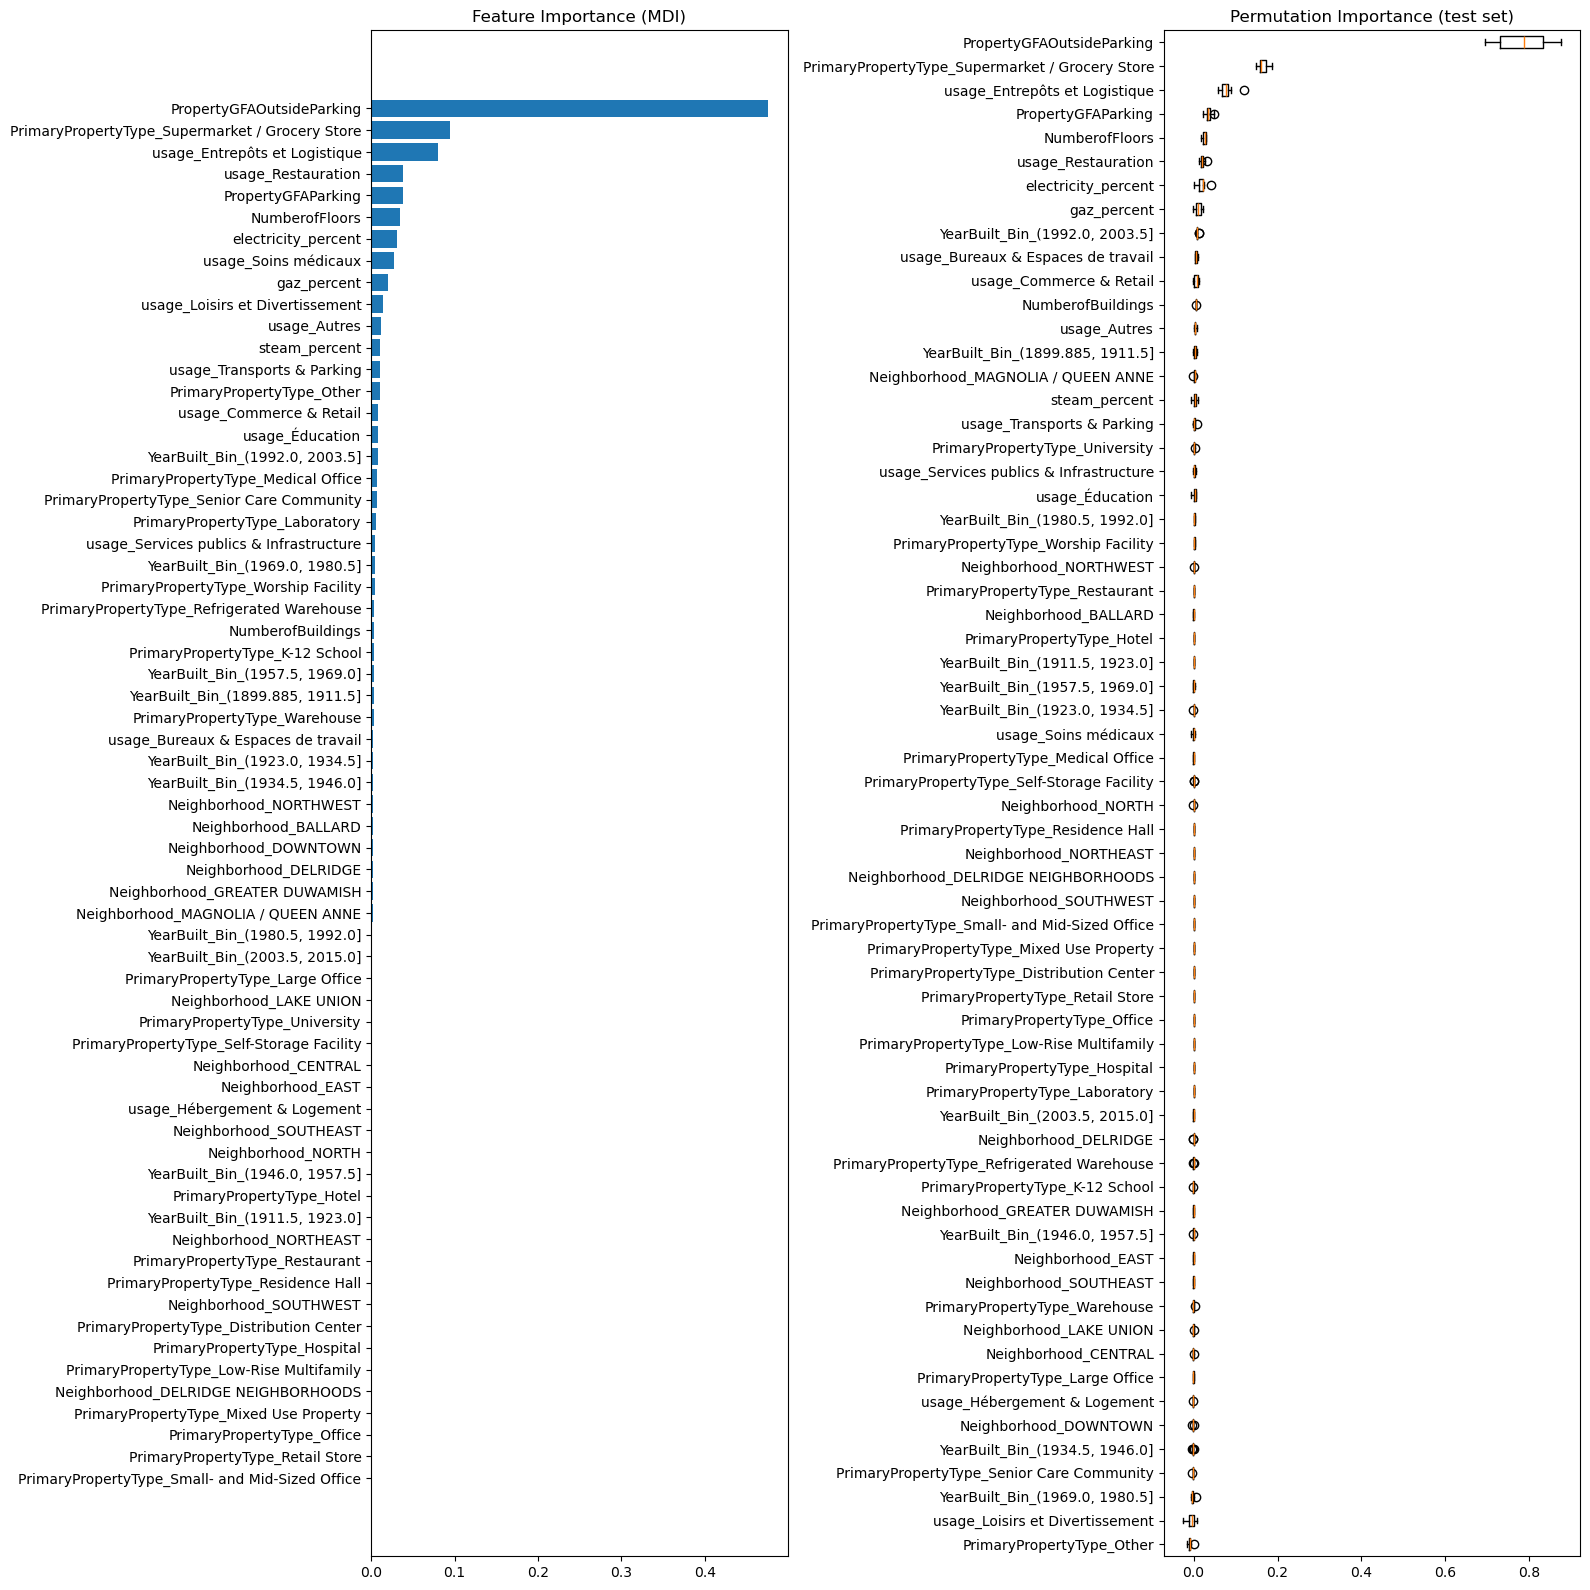

In [225]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_fe2.columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
tick_labels_dict = {
    tick_labels_parameter_name: np.array(X_fe2.columns)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

*Permutation Feature Importance*

Cette méthode mesure l’impact sur l’erreur de prédiction lorsque les valeurs d’une feature sont permutées. On observe sur le diagramme ci-dessus à droite, que l'erreur de prédiction est plus importante quand on permutte les features "PropertyGFAOutsideParking", "PrimaryPropertyType_Supermarket / Grocery Store", "usage_Entrepôts et Logistique" et "PropertyGFAParking".

#### 5.2 - Création d’un objet explicatif (LinearExplainer)

Nous devrons créer un objet explicatif afin de tracer divers graphiques expliquant une prédiction particulière.

Nous allons commencer par créeTreearExplainer qui est couramment utilisé pour lgradient boosting regressor.re

In [228]:
gradient_reg_explainer1 = shap.TreeExplainer(best_model, X_train)

Calculer les valeurs SHAP pour l'échantillon : Ces valeurs indiquent comment chaque caractéristique (ou feature) contribue à la prédiction en déviant de la "valeur de base" (ou base value, aussi appelée valeur attendue).

La valeur attendue représente la moyenne des prédictions du modèle (ou une autre valeur de référence) avant de tenir compte des caractéristiques spécifiques.

In [230]:
# Sélection de l’échantillon - L’échantillon à analyser est défini par son index dans X_test (ici, le premier échantillon)
sample_idx = 0

# Calcul des valeurs SHAP
shap_vals = gradient_reg_explainer1.shap_values(X_test[sample_idx])

print("Expected/Base Value : ", gradient_reg_explainer1.expected_value)   # Affichage de la valeur attendue (base value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)  # Montre les contributions des caractéristiques de l’échantillon au score final du modèle.
print("\n")
# Prédit la valeur pour cet échantillon à l’aide du modèle (gradient_reg_explainer1g)
# Attention le TreeExplainer n'a pas de fonction "predict", contrairement au LinearExplainer
print("Prediction From Model                            : ", best_model.predict(X_test[sample_idx].reshape(1, -1))[0])

# Vérifie que la somme de la valeur de base et des valeurs SHAP correspond exactement à la prédiction du modèle.
# Cela illustre que les valeurs SHAP décomposent correctement la prédiction du modèle.
print("Prediction From Adding SHAP Values to Base Value : ", gradient_reg_explainer1.expected_value + shap_vals.sum())

Expected/Base Value :  4137791.5125232167

Shap Values for Sample 0 :  [-4.32082543e+03 -5.24117572e+04  1.34498453e+06 -1.87694022e+04
  4.30027750e+03  0.00000000e+00  0.00000000e+00 -6.02036845e+04
  0.00000000e+00 -1.23221543e+04 -1.12064948e+04  1.92247145e+04
  0.00000000e+00  0.00000000e+00 -1.05601742e+04  0.00000000e+00
  0.00000000e+00  1.17646582e+04  1.24713223e+03 -1.20274078e+03
  3.30723047e+03 -7.04791094e+02  0.00000000e+00 -4.01450894e+04
  1.51439563e+03  3.92998608e+05  4.34801781e+03  0.00000000e+00
  0.00000000e+00 -1.08962719e+03  9.39615492e+03  0.00000000e+00
  7.33400180e+04  0.00000000e+00 -7.57682188e+04  0.00000000e+00
  0.00000000e+00 -9.69118535e+04 -6.91373727e+03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.87311188e+03  0.00000000e+00
  0.00000000e+00 -1.12963385e+05 -1.94665600e+04  3.12148125e+03
  1.24726307e+04 -3.97259131e+05 -1.80168841e+05 -1.04883280e+05
 -4.04041065e+04  9.31891672e+04 -8.48120053e+04  4.44267186e+05
 -4.67668766e+03 -4

Quelles sont les valeurs des features du 1er échantillon ?

In [460]:
# Associer noms et valeurs
for col, val in zip(X_fe2.columns, X_test[0]):
    print(f"{col}: {val}")

NumberofBuildings: -0.13173412742202079
NumberofFloors: 0.514151188771611
PropertyGFAParking: 2.7554152041374
Neighborhood_BALLARD: -0.21566554640687685
Neighborhood_CENTRAL: -0.18368486387701127
Neighborhood_DELRIDGE: -0.17544299181976059
Neighborhood_DELRIDGE NEIGHBORHOODS: -0.026361468712148235
Neighborhood_DOWNTOWN: -0.4814790443471277
Neighborhood_EAST: -0.27755746270091947
Neighborhood_GREATER DUWAMISH: -0.5420337065935641
Neighborhood_LAKE UNION: -0.3028797843376553
Neighborhood_MAGNOLIA / QUEEN ANNE: -0.3150184775872266
Neighborhood_NORTH: -0.21566554640687685
Neighborhood_NORTHEAST: 3.4771984543464143
Neighborhood_NORTHWEST: -0.2393088432694462
Neighborhood_SOUTHEAST: -0.17544299181976059
Neighborhood_SOUTHWEST: -0.16463334093438747
YearBuilt_Bin_(1899.885, 1911.5]: -0.34099716973523675
YearBuilt_Bin_(1911.5, 1923.0]: -0.29040893477575785
YearBuilt_Bin_(1923.0, 1934.5]: -0.32425604087826576
YearBuilt_Bin_(1934.5, 1946.0]: -0.18368486387701125
YearBuilt_Bin_(1946.0, 1957.5]: -0

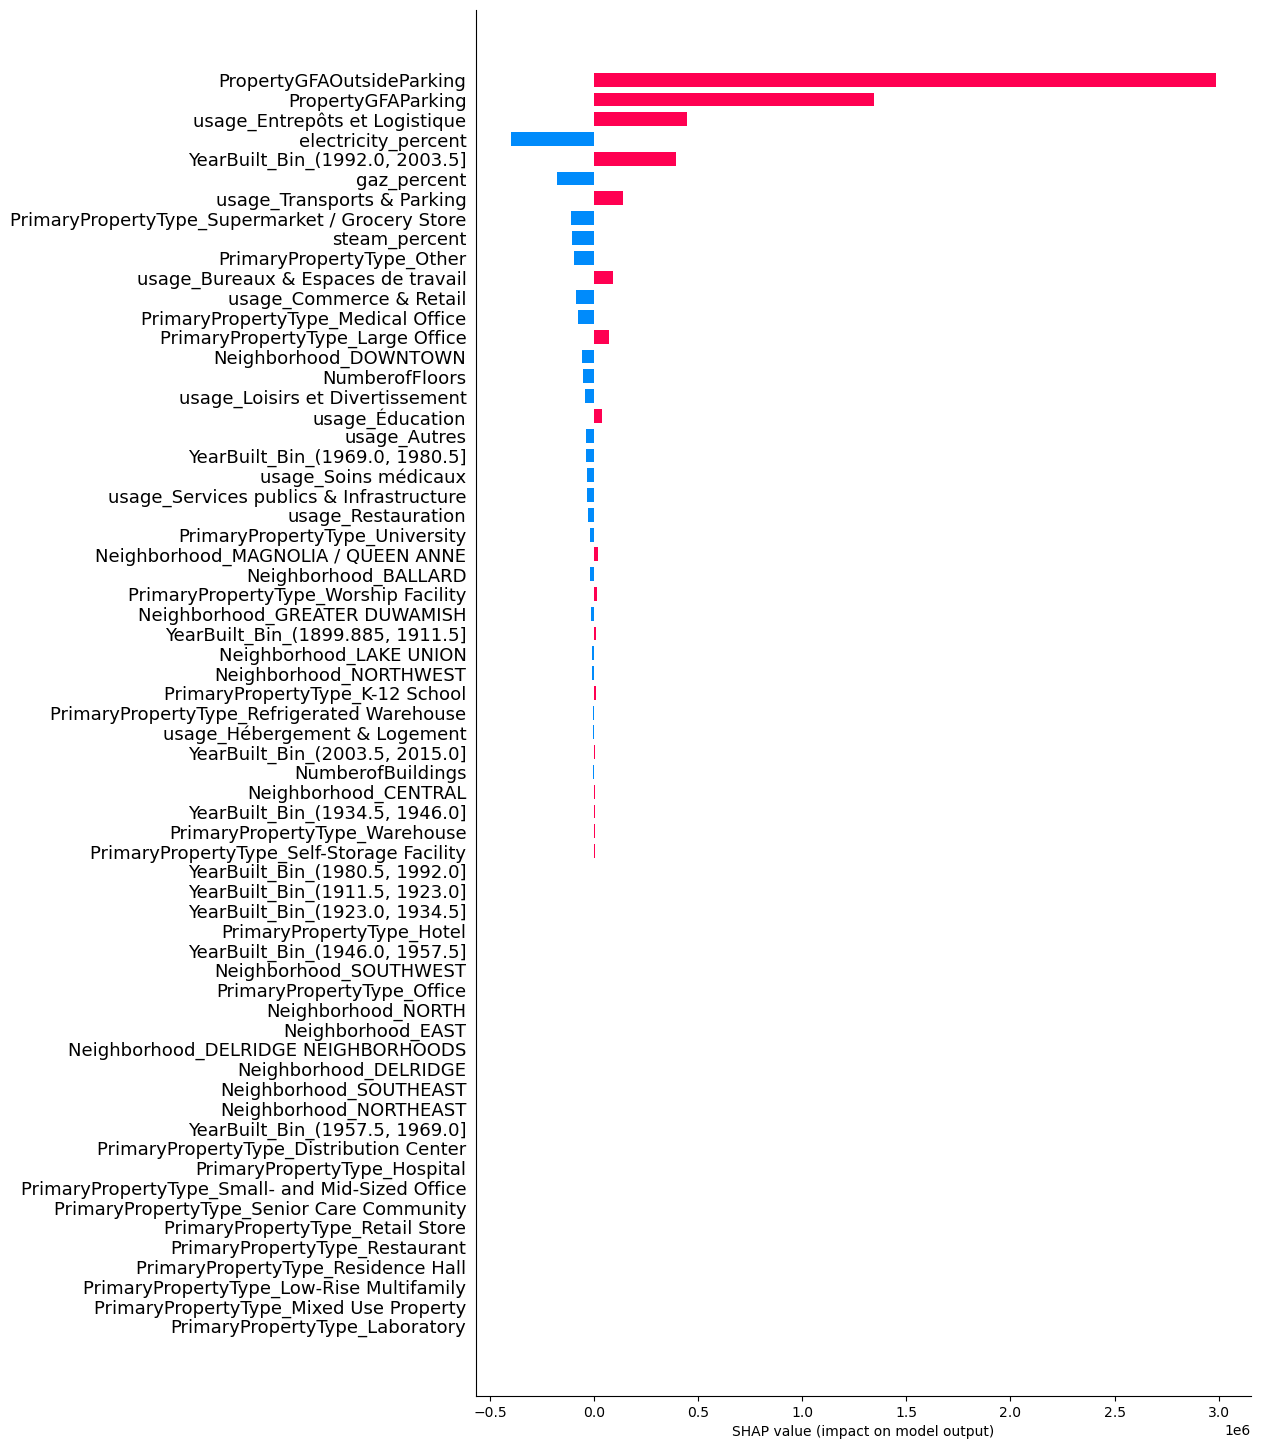

In [431]:
plt.figure(figsize=(10, 18))

shap.bar_plot(gradient_reg_explainer1.shap_values(X_test[0]),
              feature_names=X_fe2.columns,
              max_display=len(X_fe2.columns))

In [ ]:
Les contributions négatives de la répartition electricité / gaz / vapeur peuvent être étonnantes, mais quand on regarde la mtrice de corrélation suivante, tout s'explique :

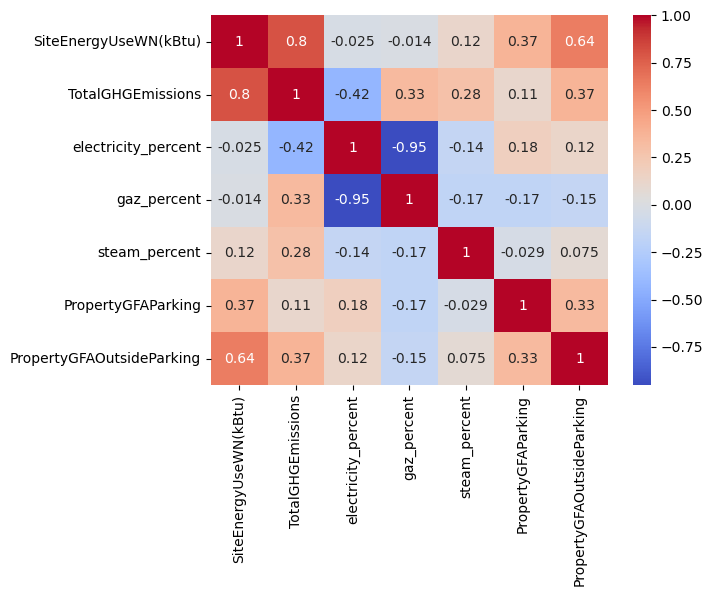

In [499]:
correlation_matrix = data_fe2[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'electricity_percent', 'gaz_percent', 'steam_percent', \
                           'PropertyGFAParking', 'PropertyGFAOutsideParking']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On observe que :
- Les 2 features de surface sont corrélées positivement à la variable cible
- La répartion des sources d'énergie n'est pas corrélée à la variable cible

De plus il s'agit de la répartition des sources d'energie, en pourcentage, non une valeur de consommation d'électricité, de gaz, ou de vapeur. C'est pour cette r

#### 5.3 - Diagrammes à barres

Le graphique à barres affiche les valeurs de shap de chaque entité pour un échantillon particulier de données. Vous trouverez ci-dessous une liste des paramètres importants de la méthode bar_plot() de shap.

shap_values : il accepte un tableau de valeurs shap pour un échantillon individuel de données.
feature_names - Il accepte une liste de noms de fonctionnalités.
max_display : il accepte les entiers spécifiant le nombre de fonctionnalités à afficher dans un graphique à barres.

Barres rouges (droite, contribution positive) : Ces caractéristiques augmentent la prédiction du modèle par rapport à la valeur de base (ou expected value). Elles poussent la prédiction vers une valeur plus élevée.

Barres bleues (gauche, contribution négative) : Ces caractéristiques diminuent la prédiction du modèle par rapport à la valeur de base. Elles tirent la prédiction vers une valeur plus basse.

Si la prédiction du modèle est une valeur élevée, on peut dire que cela est principalement dû à des valeurs élevées de PropertyGFAOutsideParking et PropertyGFAParking.
Les caractéristiques liées à l’électricité (par ex. electricity_percent) ont contribué à diminuer la prédiction.

#### 5.4 - Tracé en cascade

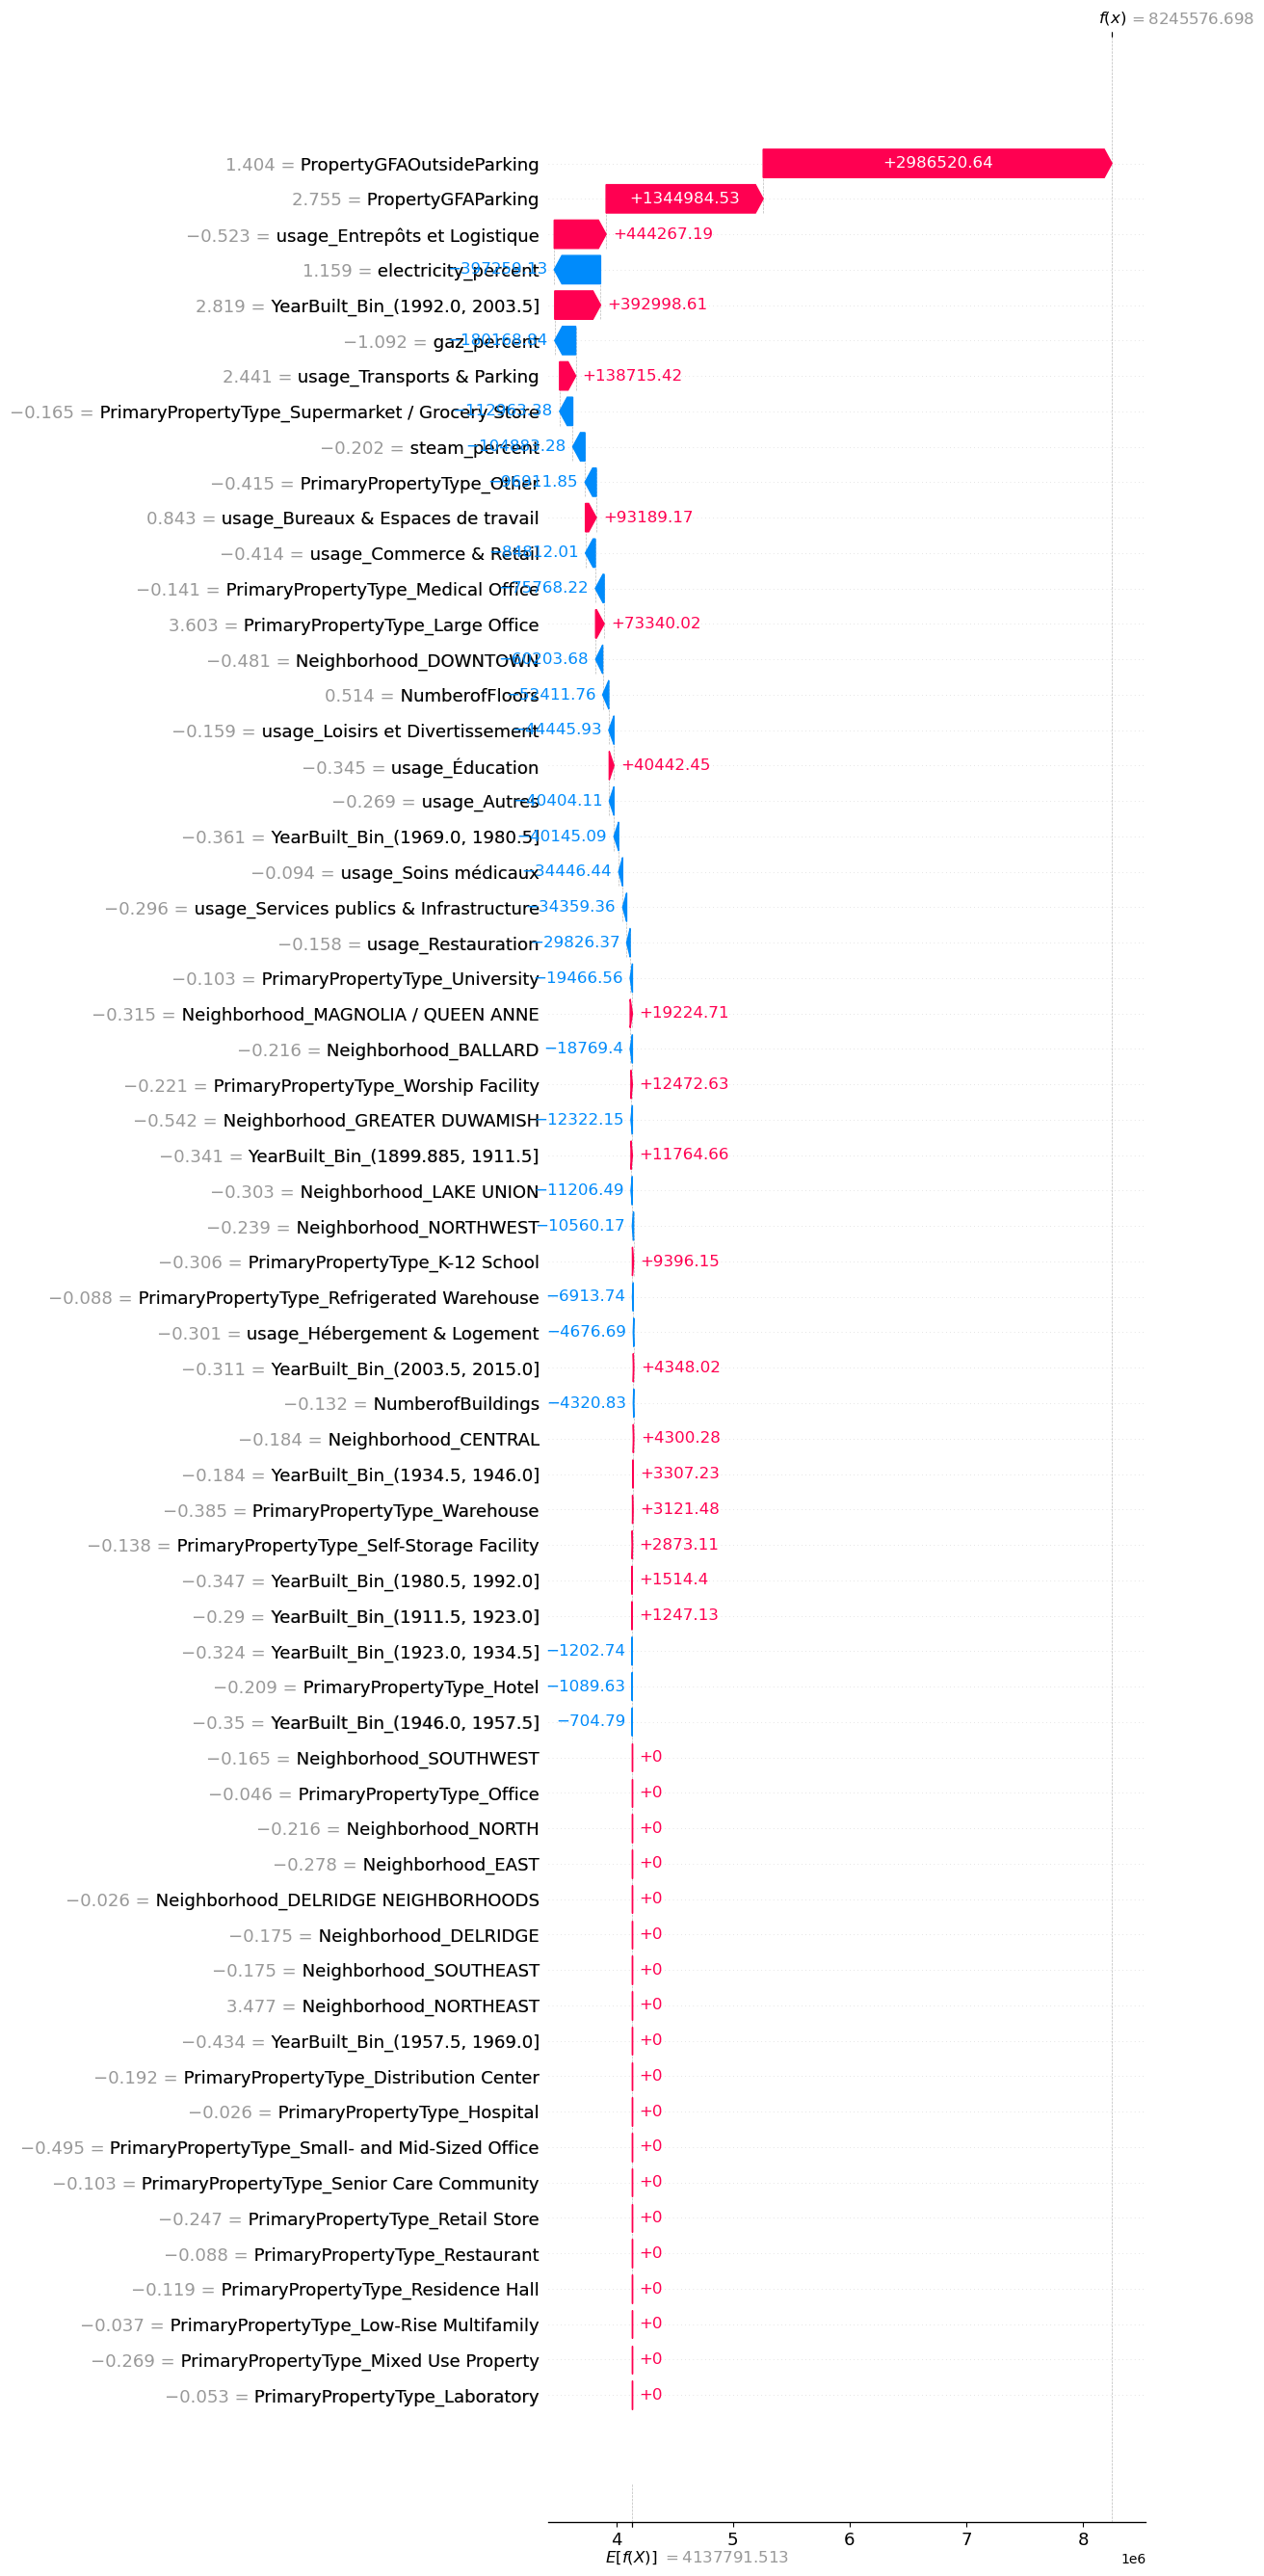

In [235]:
plt.figure(figsize=(60, 18))

shap_values = gradient_reg_explainer1(X_test[:1])
shap_values.feature_names = X_fe2.columns.tolist()

shap.waterfall_plot(shap_values[0], max_display=len(X_fe2.columns))

Le point à droite f(x)=8245576.698 représente la prédiction finale du modèle pour cet exemple spécifique.

La valeur est la somme de : 
- La valeur de base (expected/base value) : la moyenne des prédictions du modèle sur tout l'ensemble de données.
- Les contributions des caractéristiques individuelles : les valeurs SHAP.

Barres rouges et bleues : Contributions des caractéristiques
- Rouge (valeurs positives) : Ces caractéristiques augmentent la prédiction en poussant la valeur prédite vers le haut.
- Bleu (valeurs négatives) : Ces caractéristiques réduisent la prédiction, c'est-à-dire qu'elles ont un effet de diminution sur f(x).

Les caractéristiques comme PropertyGFAOutsideParking et PropertyGFAParking ont les contributions les plus importantes et augmentent la prédiction.

usage_Entrepôts et Logistique a un effet modéré mais négatif, réduisant légèrement la prédiction.

D'autres caractéristiques comme Neighborhood_DOWNTOWN ou PrimaryPropertyType_Large Office ont un impact beaucoup plus faible sur cette prédiction.

**Tracé en cascade personnalisé pour plus de lisibilité**

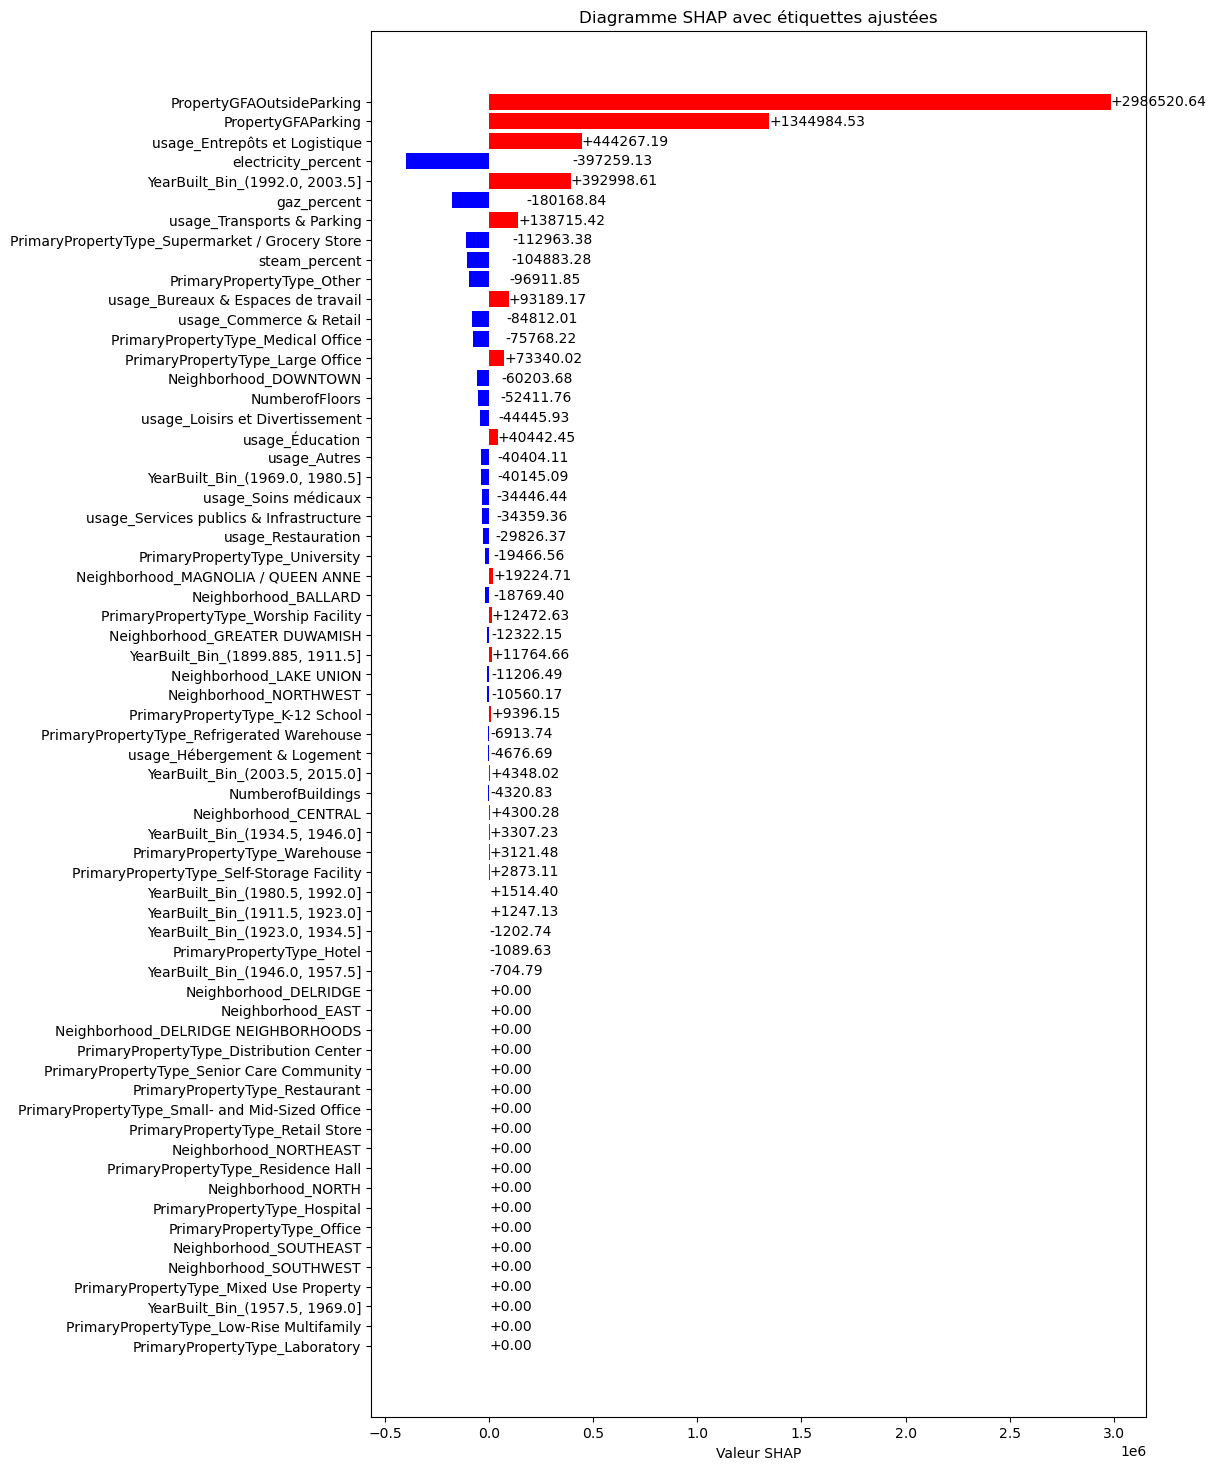

In [238]:
# Récupérer les données nécessaires
shap_values = gradient_reg_explainer1.shap_values(X_test[0])
feature_names = X_fe2.columns

# Trier les valeurs SHAP et les noms des caractéristiques par importance absolue
sorted_idx = np.argsort(np.abs(shap_values))[::-1]
shap_values = shap_values[sorted_idx]
feature_names = feature_names[sorted_idx]

# Création du graphique personnalisé
plt.figure(figsize=(10, 18))
for i, (value, name) in enumerate(zip(shap_values, feature_names)):
    color = "red" if value > 0 else "blue"
    plt.barh(i, value, color=color)
    plt.text(abs(value), i, f"{value:+.2f}", va='center')  # Toujours à droite

# Ajouter les noms des caractéristiques
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Valeur SHAP")
plt.title("Diagramme SHAP avec étiquettes ajustées")
plt.gca().invert_yaxis()
plt.show()

#### 5.5 - Diagramme de décision

D'abord sur un échantillon :

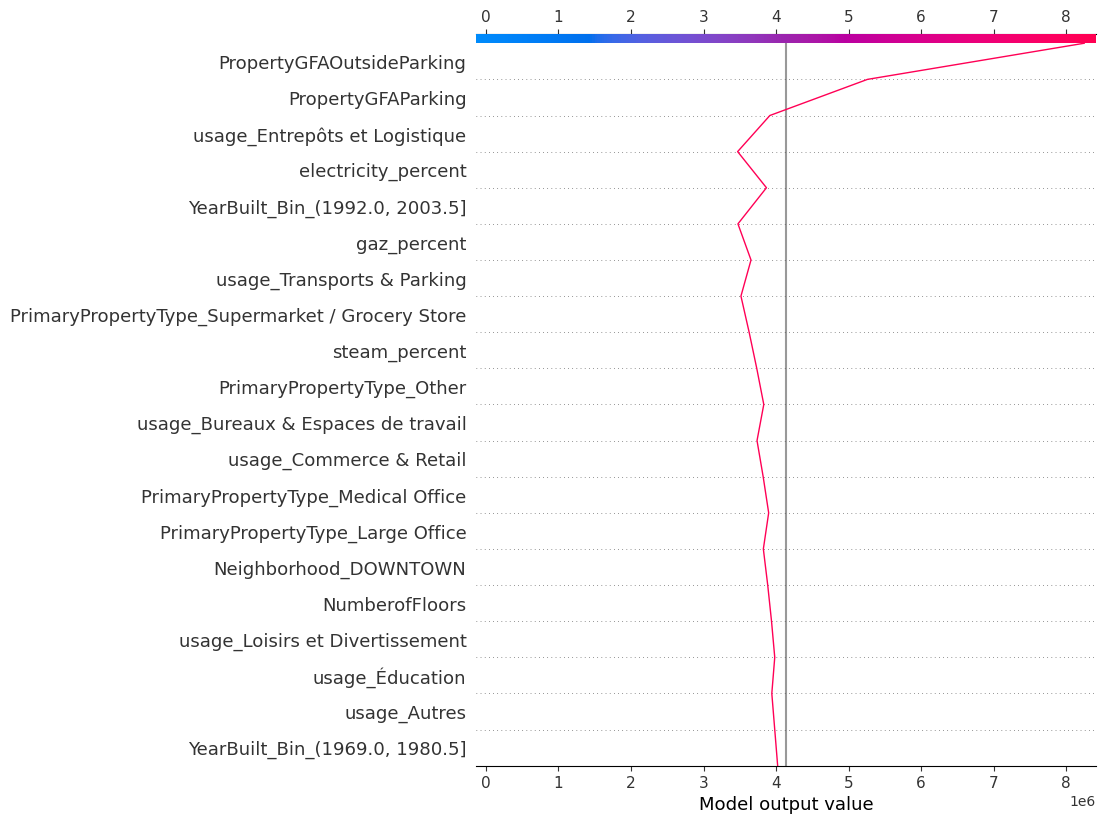

In [240]:
shap.decision_plot(gradient_reg_explainer1.expected_value,
                   gradient_reg_explainer1.shap_values(X_test[0]),
                   feature_names=X_fe2.columns.tolist(),
                   )

Puis sur 20 échantillons :

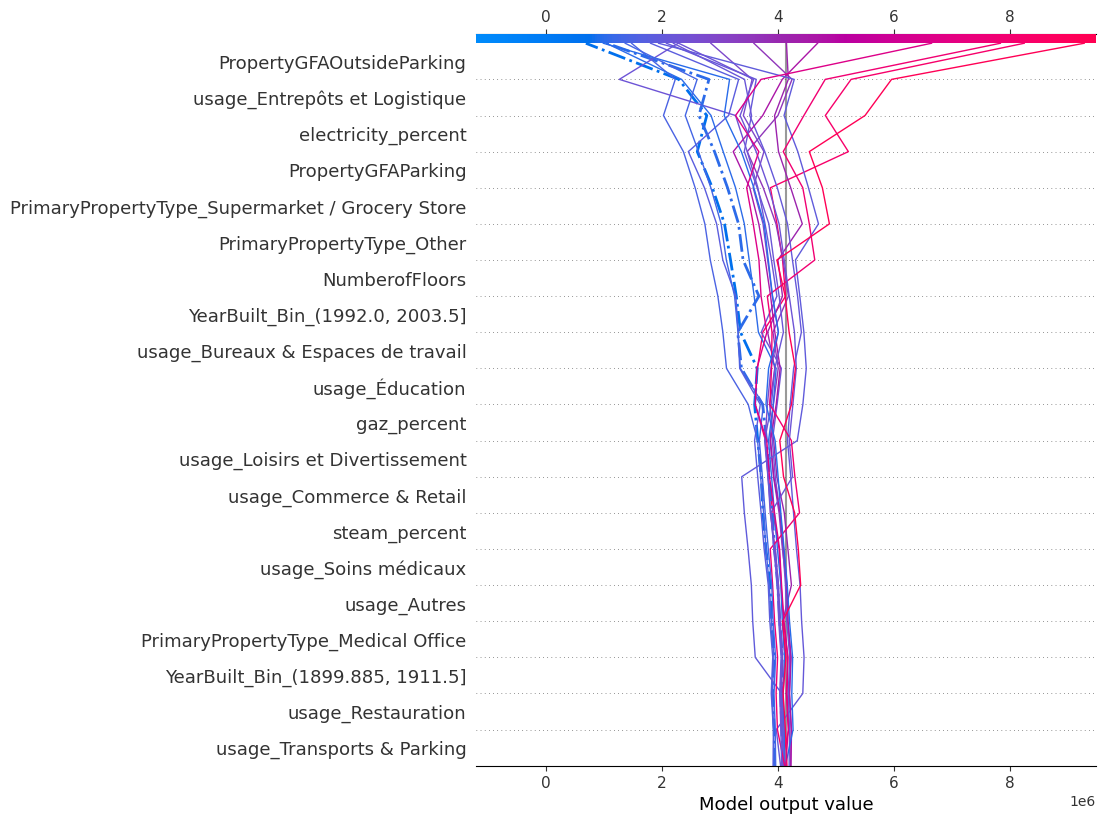

In [442]:
shap.decision_plot(gradient_reg_explainer1.expected_value,
                   gradient_reg_explainer1.shap_values(X_test[0:20]),
                   feature_names=X_fe2.columns.tolist(),
                   highlight=[1, 2],
                   )

#### 5.6 - Diagramme de dépendance

Le graphique de dépendance montre la relation entre la valeur réelle de la caractéristique et les valeurs de shap pour une caractéristique particulière du jeu de données

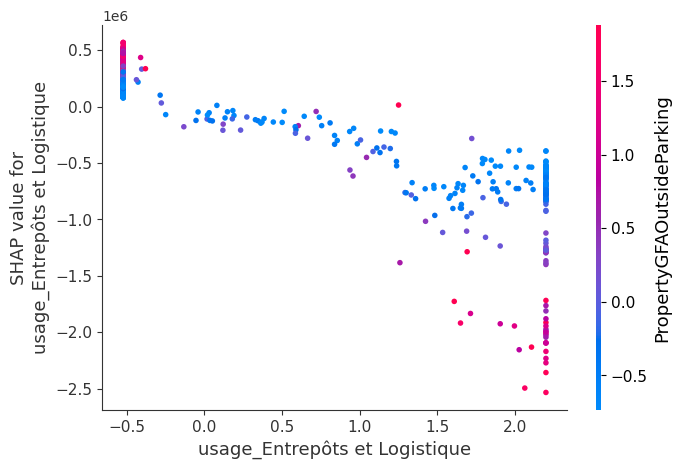

In [244]:
shap.dependence_plot("usage_Entrepôts et Logistique",
                     gradient_reg_explainer1.shap_values(X_train),
                     features=X_train,
                     feature_names=X_fe2.columns,
                     )

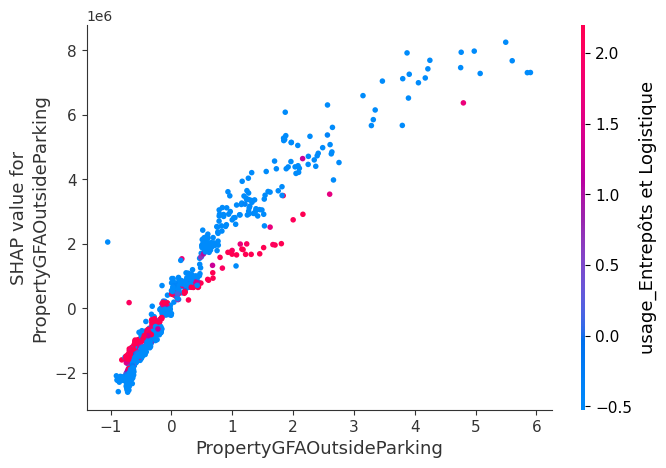

In [245]:
shap.dependence_plot("PropertyGFAOutsideParking",
                     gradient_reg_explainer1.shap_values(X_train),
                     features=X_train,
                     feature_names=X_fe2.columns,
                     )

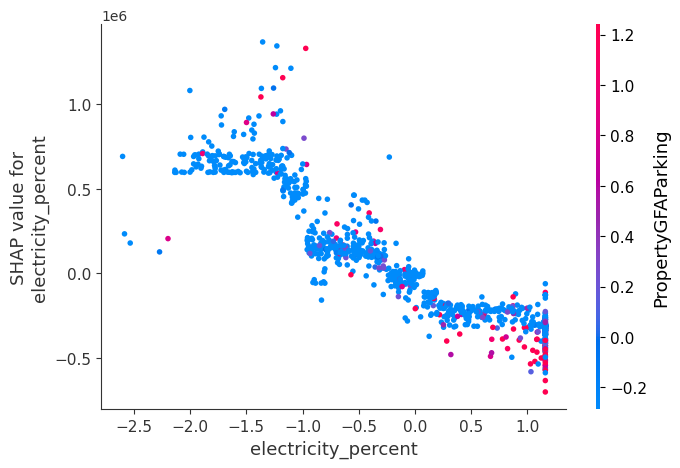

In [246]:
shap.dependence_plot("electricity_percent",
                     gradient_reg_explainer1.shap_values(X_train),
                     features=X_train,
                     feature_names=X_fe2.columns,
                     )

In [247]:
columns = ['NumberofFloors', 'PropertyGFAParking',
       'Neighborhood_DOWNTOWN', 'PrimaryPropertyType_Supermarket / Grocery Store', 'electricity_percent',
       'gaz_percent', 'steam_percent', 'usage_Bureaux & Espaces de travail', 'usage_Commerce & Retail',
       'usage_Entrepôts et Logistique', 'usage_Transports & Parking', 'usage_Éducation', 'PropertyGFAOutsideParking']

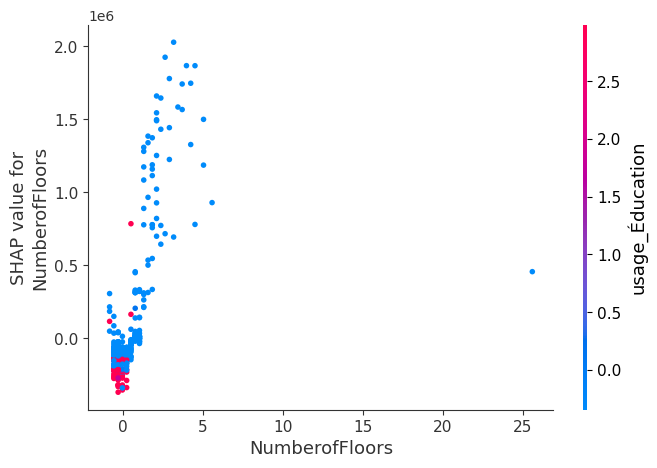

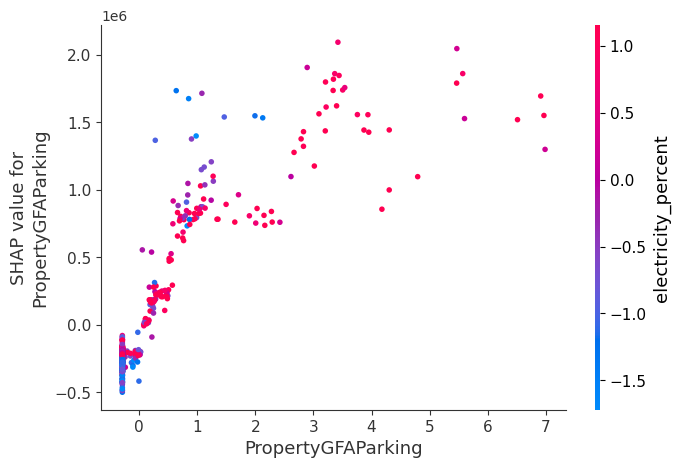

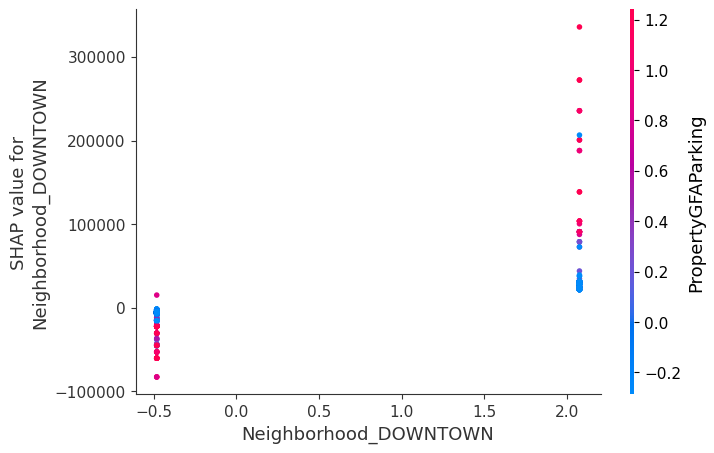

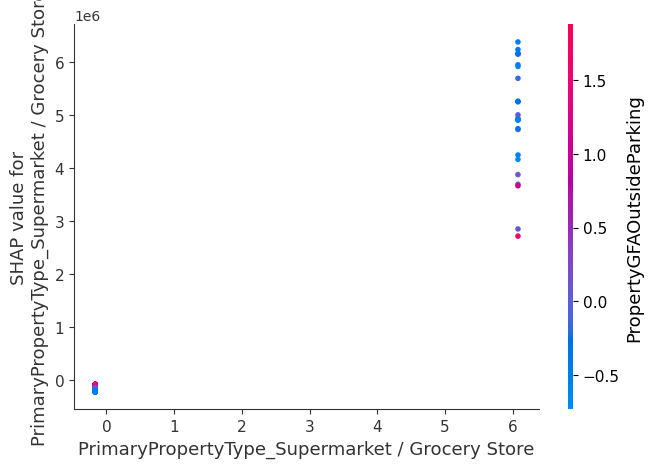

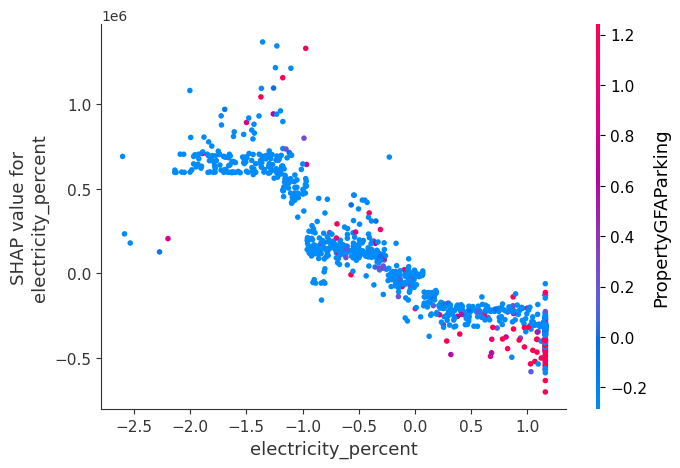

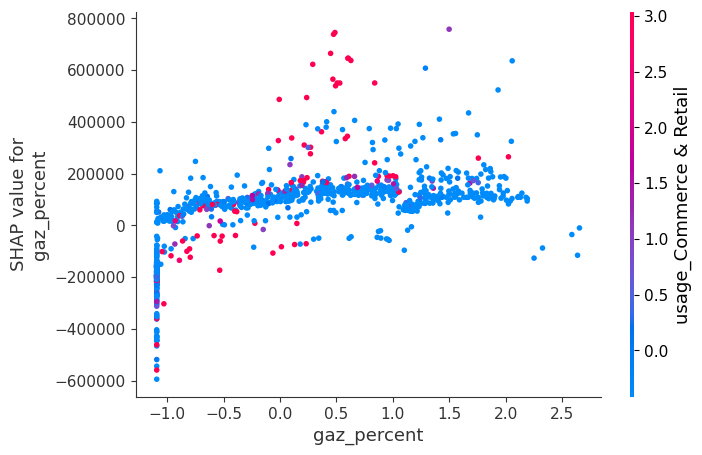

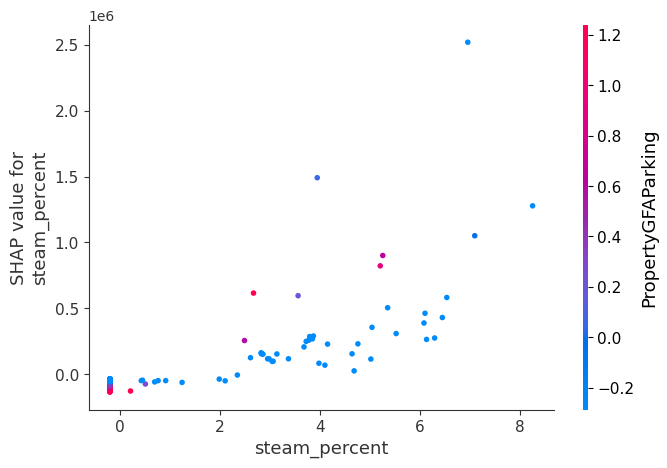

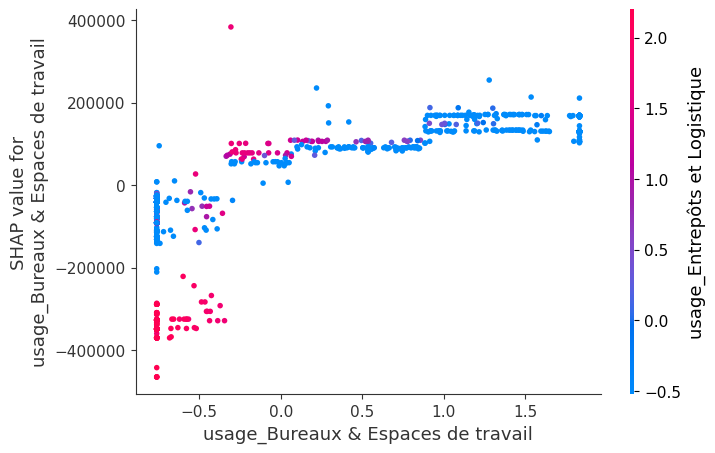

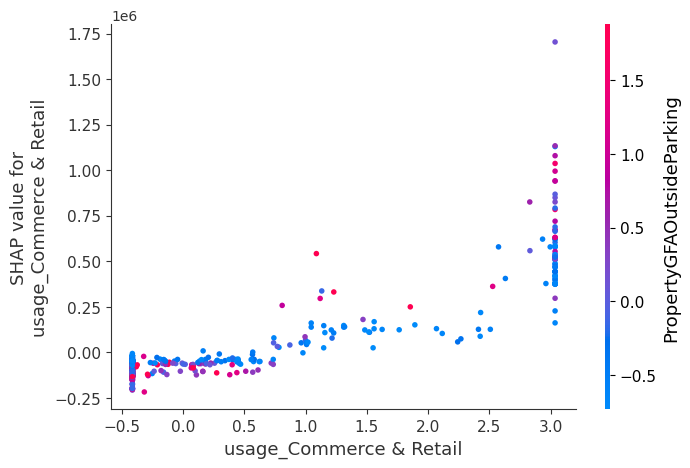

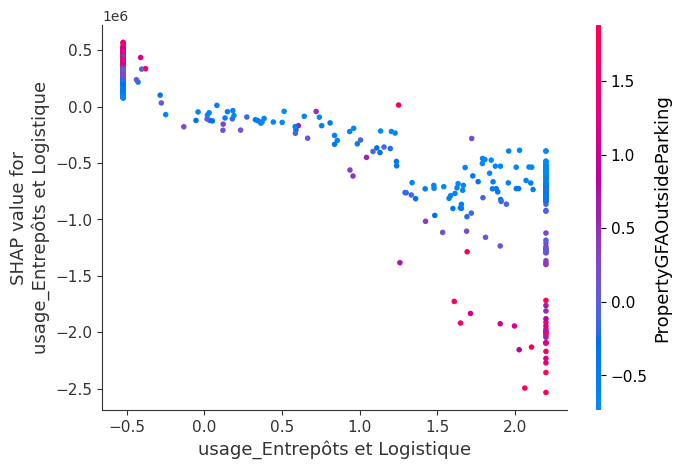

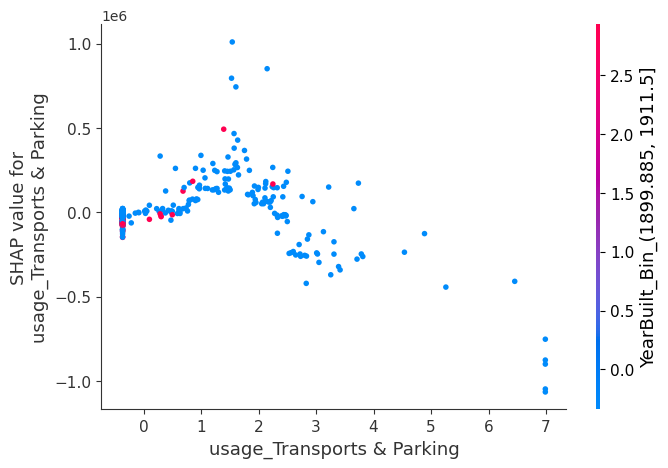

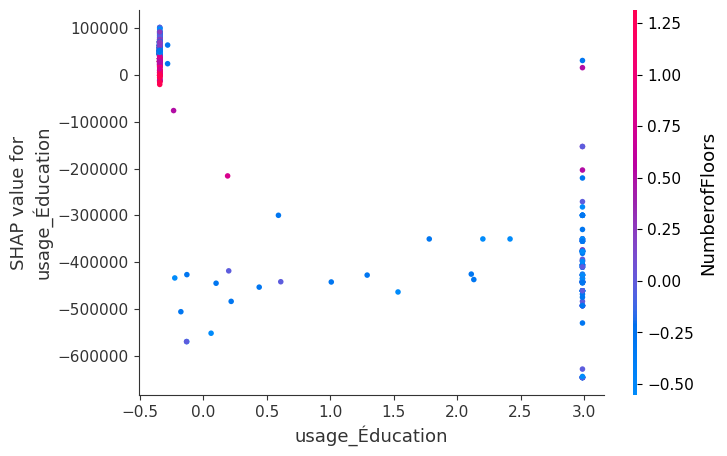

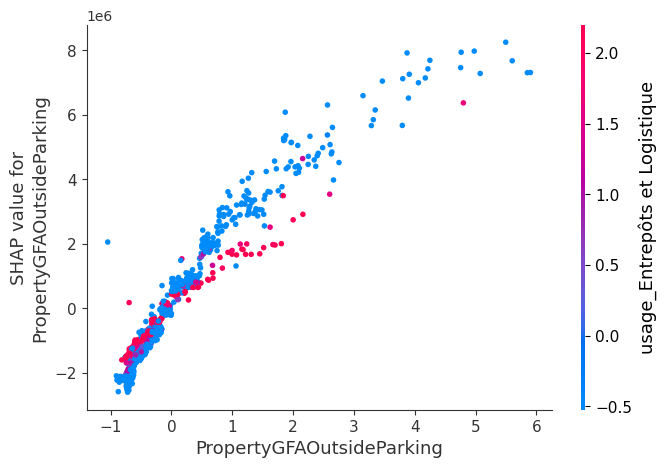

In [248]:
for feature in columns:
    shap.dependence_plot(feature,
                     gradient_reg_explainer1.shap_values(X_train),
                     features=X_train,
                     feature_names=X_fe2.columns,
                     )

#### 5.7 - Tracé de la Force

Le graphique des forces montre les contributions des valeurs de shap dans la génération de la prédiction finale à l’aide d’une disposition de force additive. Il montre quelles caractéristiques ont contribué à combien positivement ou négativement à la valeur de base pour générer une prédiction.

D'abord sur 1 échantillon :

In [250]:
shap.force_plot(gradient_reg_explainer1.expected_value,
                gradient_reg_explainer1.shap_values(X_test[0]),
                feature_names=X_fe2.columns,
                out_names="SiteEnergyUseWN(kBtu)")

Ensuite sur 10 échantillons :

In [252]:
shap.force_plot(gradient_reg_explainer1.expected_value,
                gradient_reg_explainer1.shap_values(X_test[0:10]),
                feature_names=X_fe2.columns,
                out_names="SiteEnergyUseWN(kBtu)")

#### 5.8 - Graphique récapitulatif

Le graphique récapitulatif montre le graphique de l’essaim d’abeilles montrant la distribution des valeurs shap pour toutes les caractéristiques des données

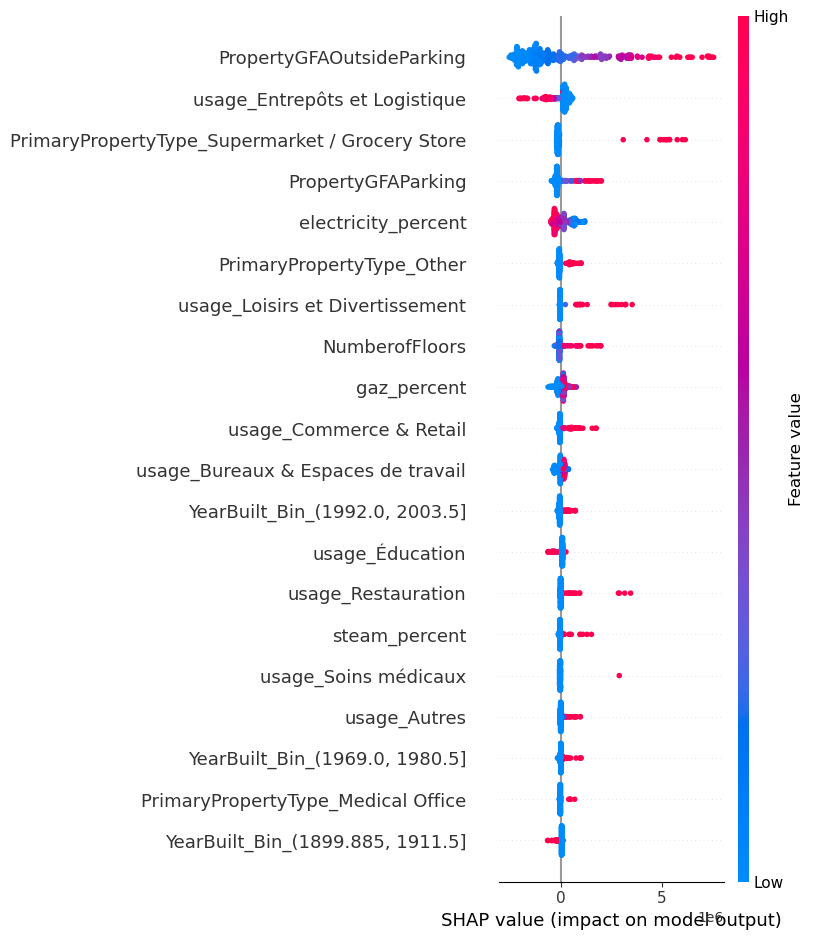

In [254]:
shap.summary_plot(gradient_reg_explainer1.shap_values(X_test),
                  features = X_test,
                  feature_names=X_fe2.columns)

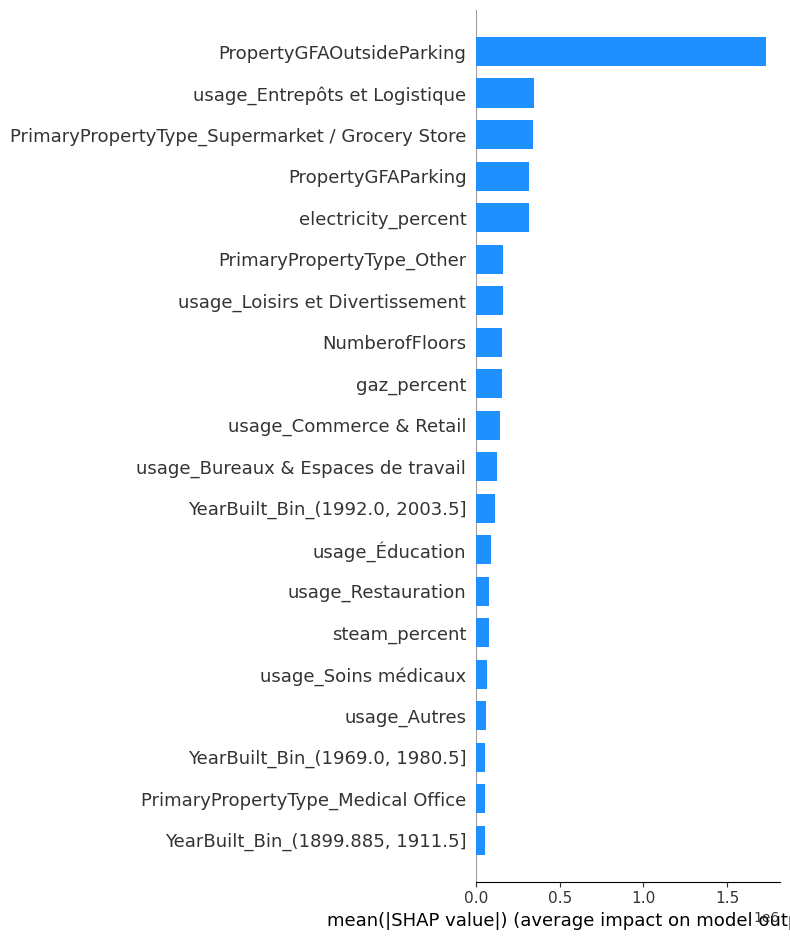

In [255]:
shap.summary_plot(gradient_reg_explainer1.shap_values(X_test),
                  feature_names=X_fe2.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )